In [63]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import numpy as np
import pandas as pd 
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [13]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [14]:
print(train.info())
print(stores.info())
print(features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------       

# Insights:

### These three files are all describing 45 store from different perspectives, and we need to merging to a whole dataframe for use.

In [15]:
df = train.merge(stores, how='left').merge(features, how='left')
test_merge = test.merge(stores, how='left').merge(features, how='left')

In [16]:
def split_date(df0):
    df0['Date'] = pd.to_datetime(df0['Date'])
    df0['Year'] = df0['Date'].dt.year
    df0['Month'] = df0['Date'].dt.month
    df0['Day'] = df0['Date'].dt.day
    df0['Week_of_year'] = df0['Date'].dt.isocalendar().week*1.0
    return df0.head(5)

# Insights:

### The day of week on each date is Friday, so the day_of_week analysis is useless.

In [20]:
split_date(df)
split_date(test_merge)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week_of_year
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44.0
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45.0
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46.0
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47.0
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48.0


For missing values

In [18]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Year                 0
Month                0
Day                  0
Week_of_year         0
dtype: int64

# 2. Exploratory data analysis

Store types

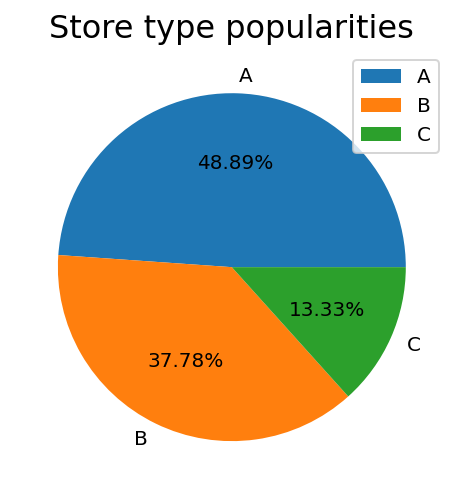

In [21]:
type_counts = stores.groupby('Type')['Store'].count().to_dict()
store_type = pd.DataFrame(list(type_counts.items()), columns=['Type', 'Counts'])
plt.pie(store_type.Counts, labels=store_type.Type, autopct='%.2f%%')
plt.title('Store type popularities', fontsize=16)
plt.legend(store_type.Type, loc='best')
plt.show()

Weeklysales - Store type

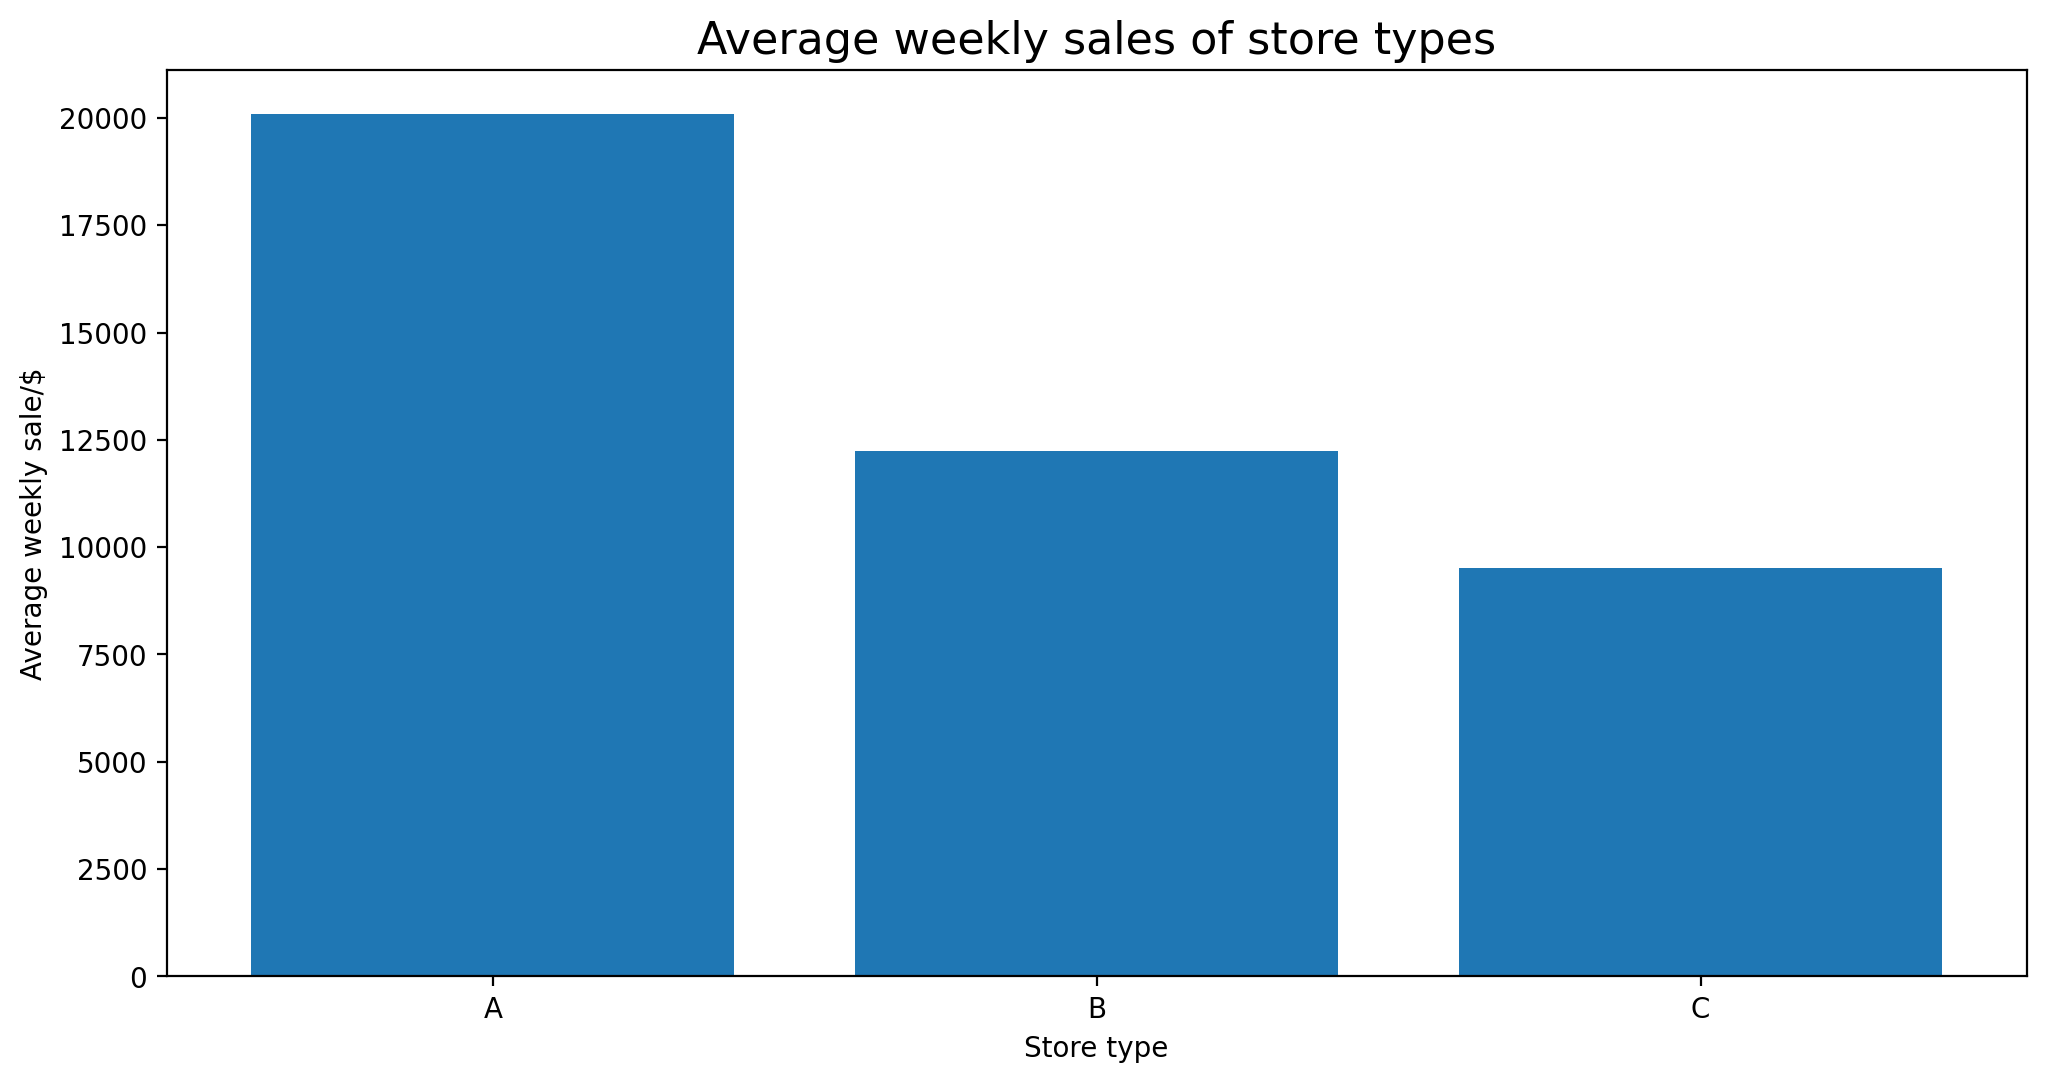

In [22]:
type_sales = df.groupby('Type')['Weekly_Sales'].mean().to_dict()
type_sales = pd.DataFrame(list(type_sales.items()), columns=['Type', 'AVG weekly_sales'])

plt.figure(figsize=(12,6), dpi=100)
plt.bar(type_sales.Type, type_sales['AVG weekly_sales'])
plt.title('Average weekly sales of store types', fontsize=16)
plt.xlabel('Store type')
plt.ylabel('Average weekly sale/$')
plt.show()

Weeklysales - Isholiday

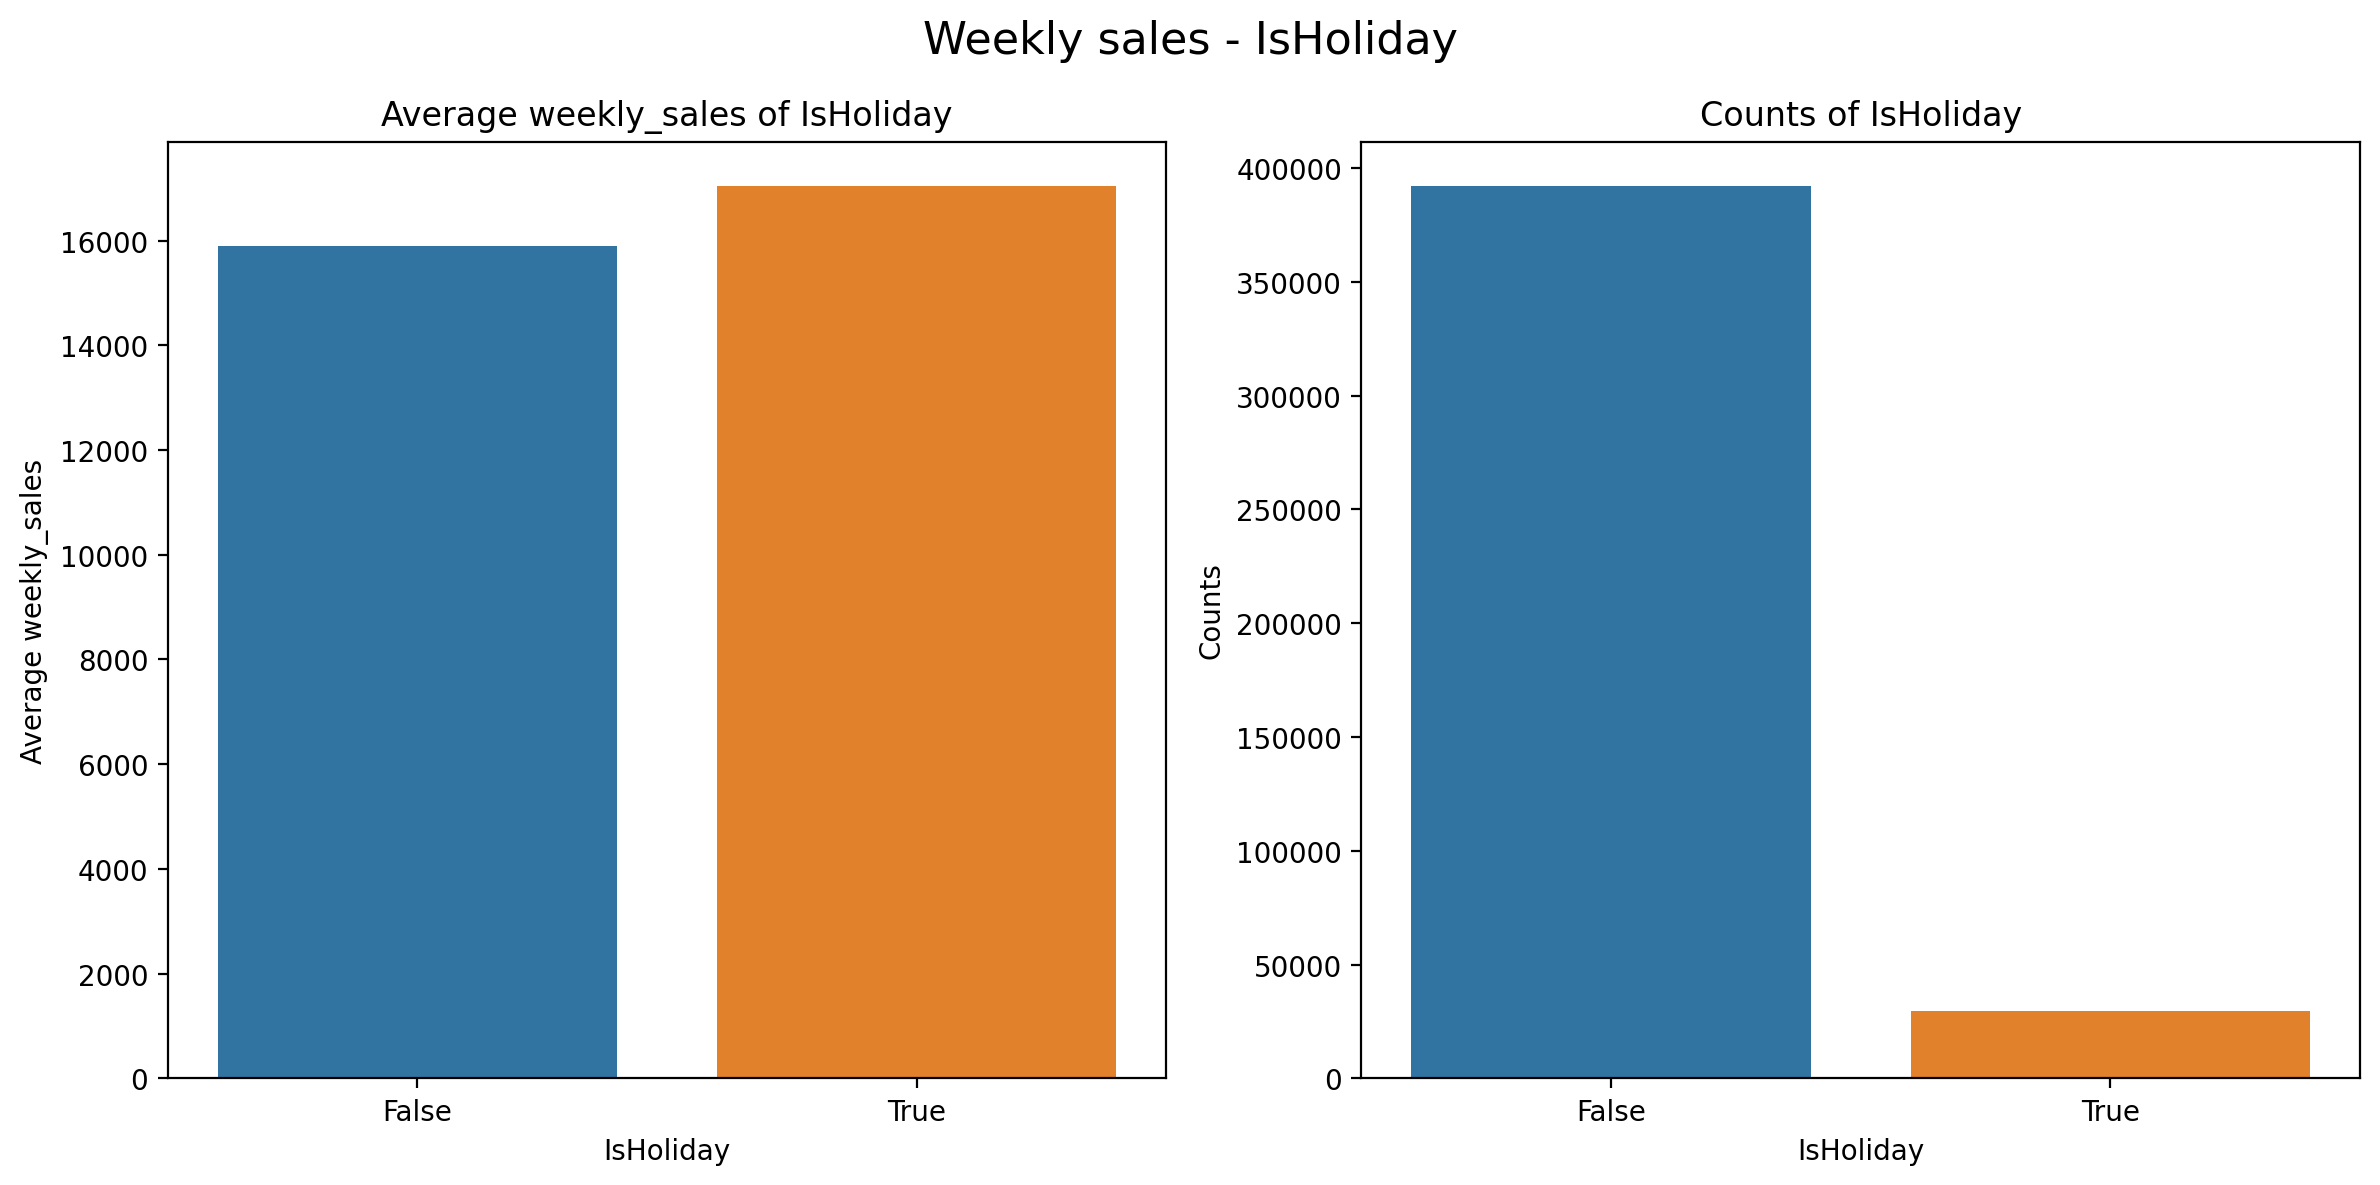

In [23]:
holiday_sale = df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_count = df.groupby('IsHoliday')['Weekly_Sales'].count()

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

ax1 = sns.barplot(x=holiday_sale.index, y=holiday_sale.values, ax=axes[0])
ax1.set_title('Average weekly_sales of IsHoliday')
ax1.set_xlabel('IsHoliday')
ax1.set_ylabel('Average weekly_sales')

ax2 = sns.barplot(x=holiday_count.index,y=holiday_count.values, ax=axes[1])
ax2.set_title('Counts of IsHoliday')
ax2.set_xlabel('IsHoliday')
ax2.set_ylabel('Counts')

plt.suptitle('Weekly sales - IsHoliday', fontsize = 16)
fig.tight_layout()
plt.show()

Weekly sale - Year

In [24]:
year_2010 = pd.DataFrame(df.loc[df['Year']==2010].groupby('Week_of_year')['Weekly_Sales'].sum()).reset_index()
year_2011 = pd.DataFrame(df.loc[df['Year']==2011].groupby('Week_of_year')['Weekly_Sales'].sum()).reset_index()
year_2012 = pd.DataFrame(df.loc[df['Year']==2012].groupby('Week_of_year')['Weekly_Sales'].sum()).reset_index()

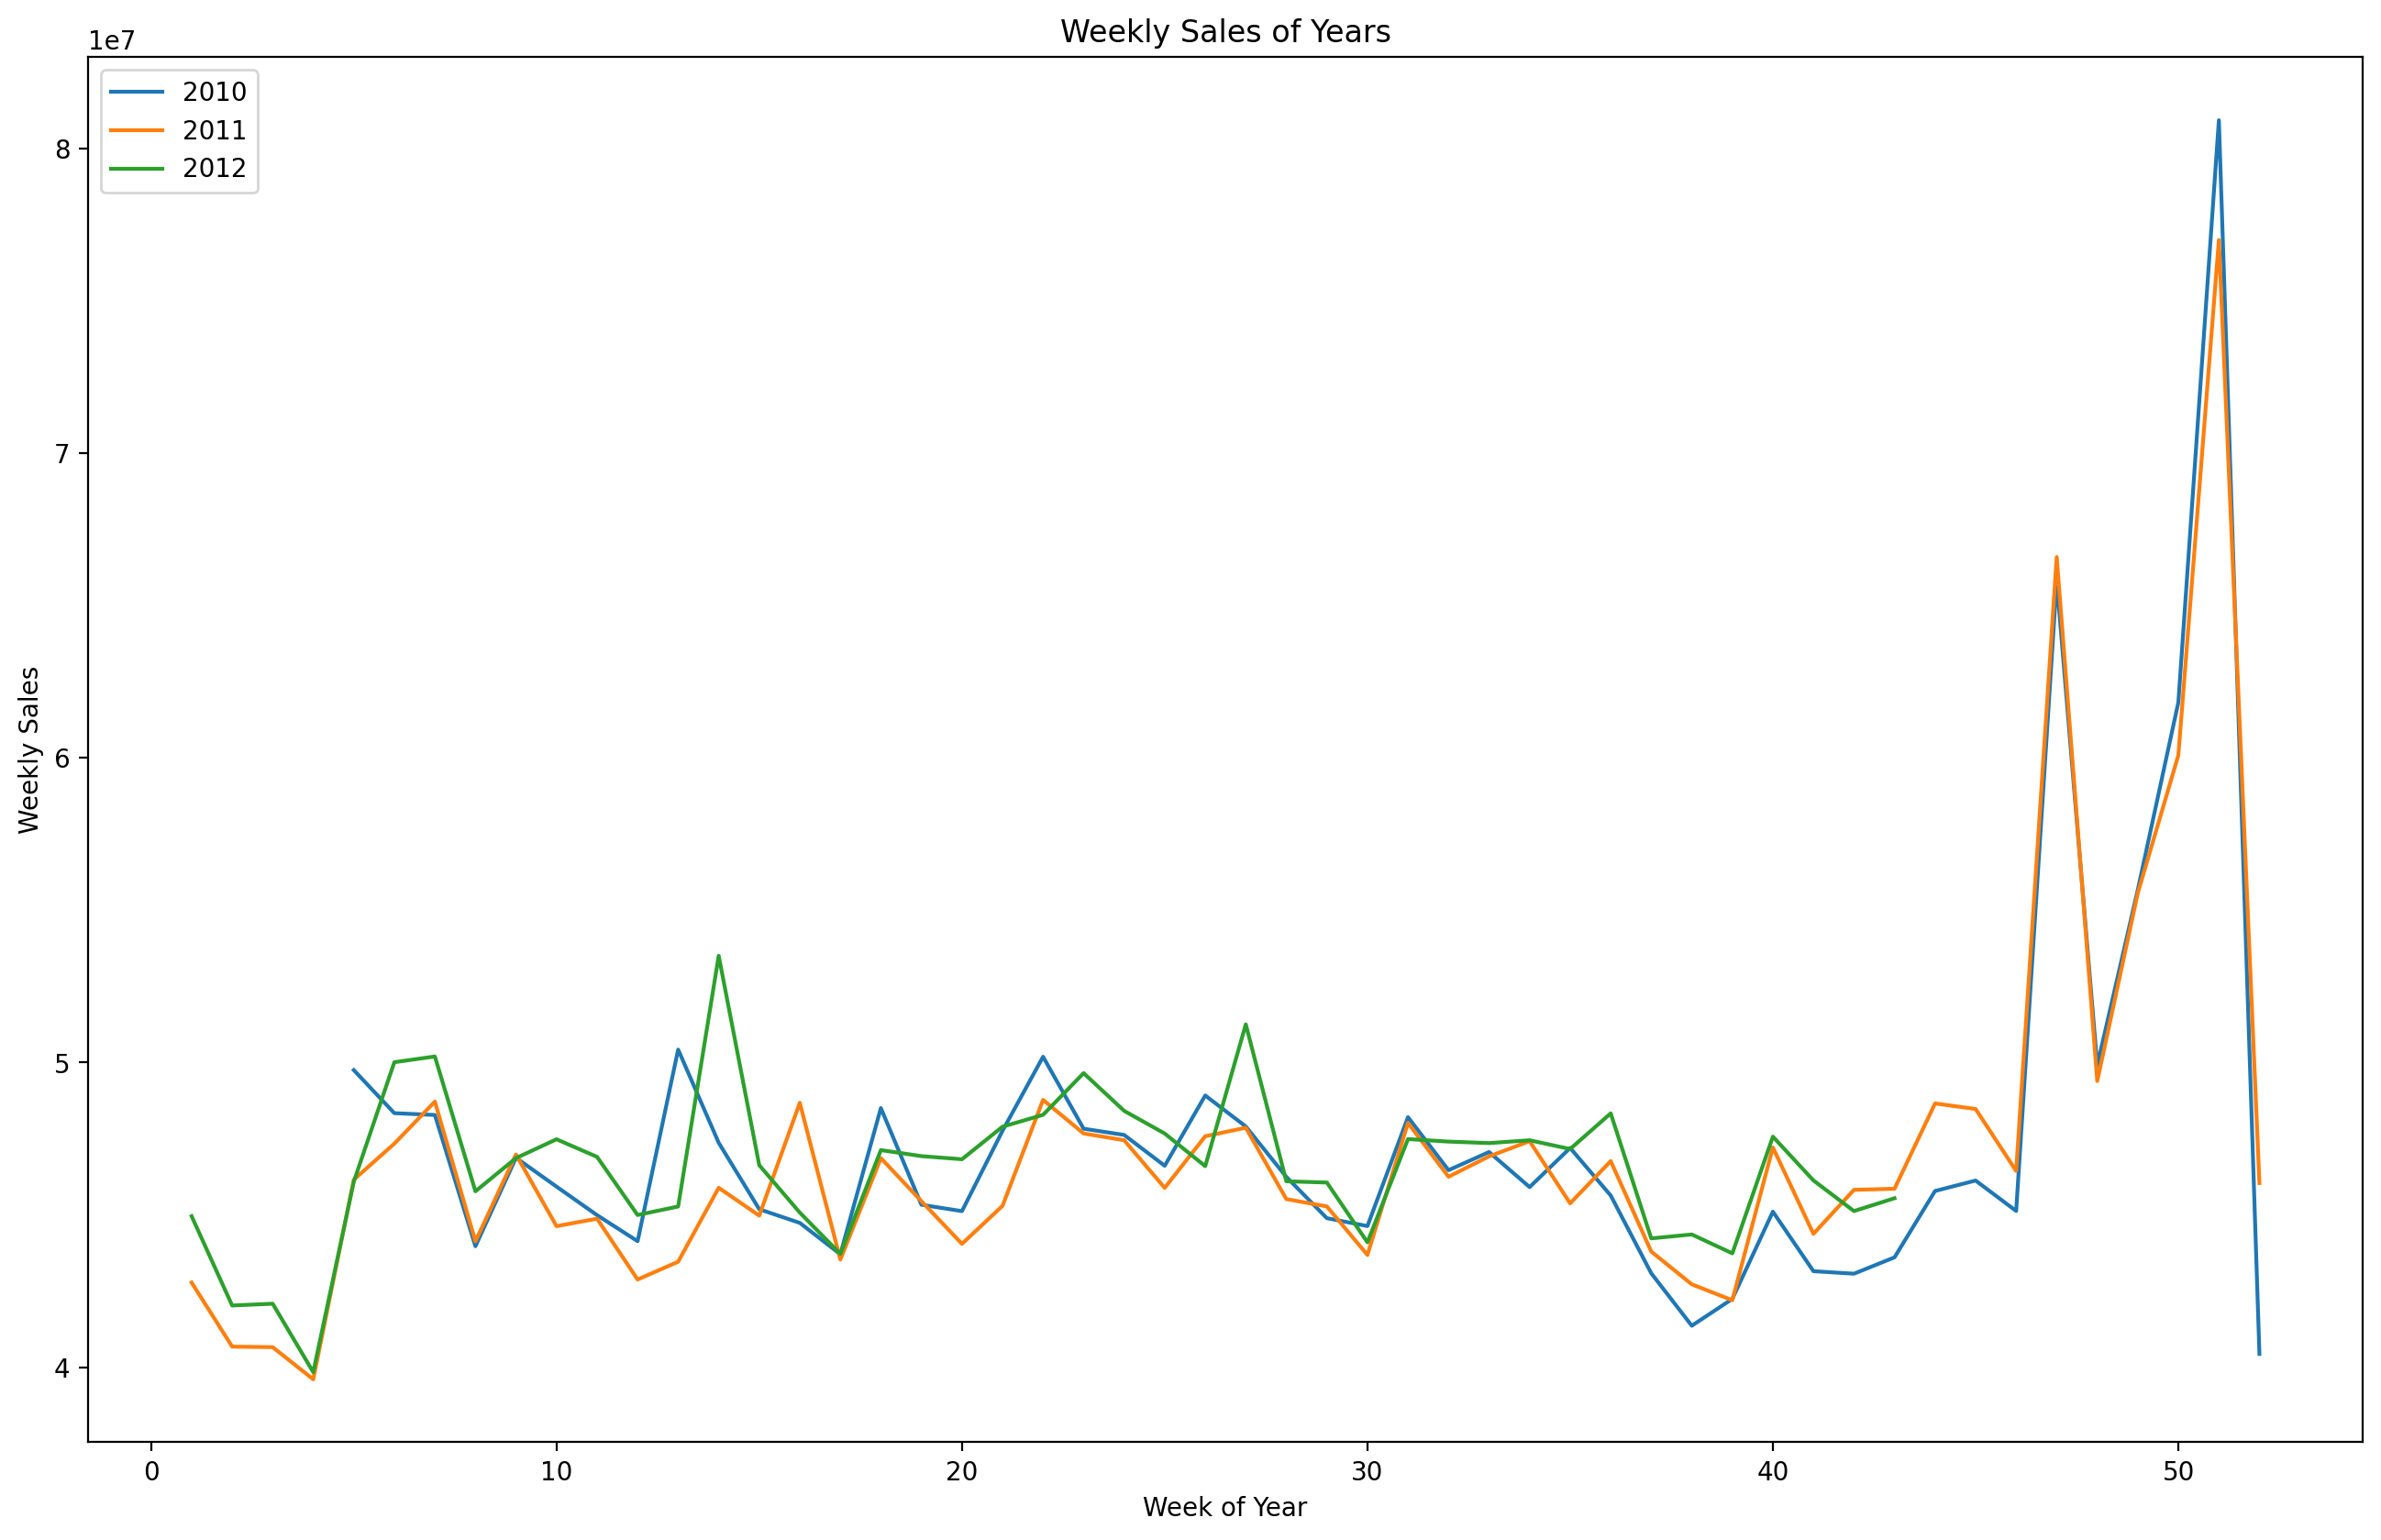

In [25]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(year_2010['Week_of_year'], year_2010['Weekly_Sales'], label='2010')
plt.plot(year_2011['Week_of_year'], year_2011['Weekly_Sales'], label='2011')
plt.plot(year_2012['Week_of_year'], year_2012['Weekly_Sales'], label='2012')

plt.legend(loc='best')
plt.xlabel('Week of Year')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales of Years')

plt.show()

In [26]:
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week_of_year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5.0
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6.0
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7.0
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8.0
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9.0


# 3. Machine Learning model
### Since we have 20 columns in total, we need to reduce the dimensionality using correlation matrix, which is only for numeric values, and the 'Type' column needs to be transferred.

In [27]:
df['Type_trans'] = df['Type'].map({'A':1, 'B':2, 'C':3})
test_merge['Type_trans'] = test_merge['Type'].map({'A':1, 'B':2, 'C':3})

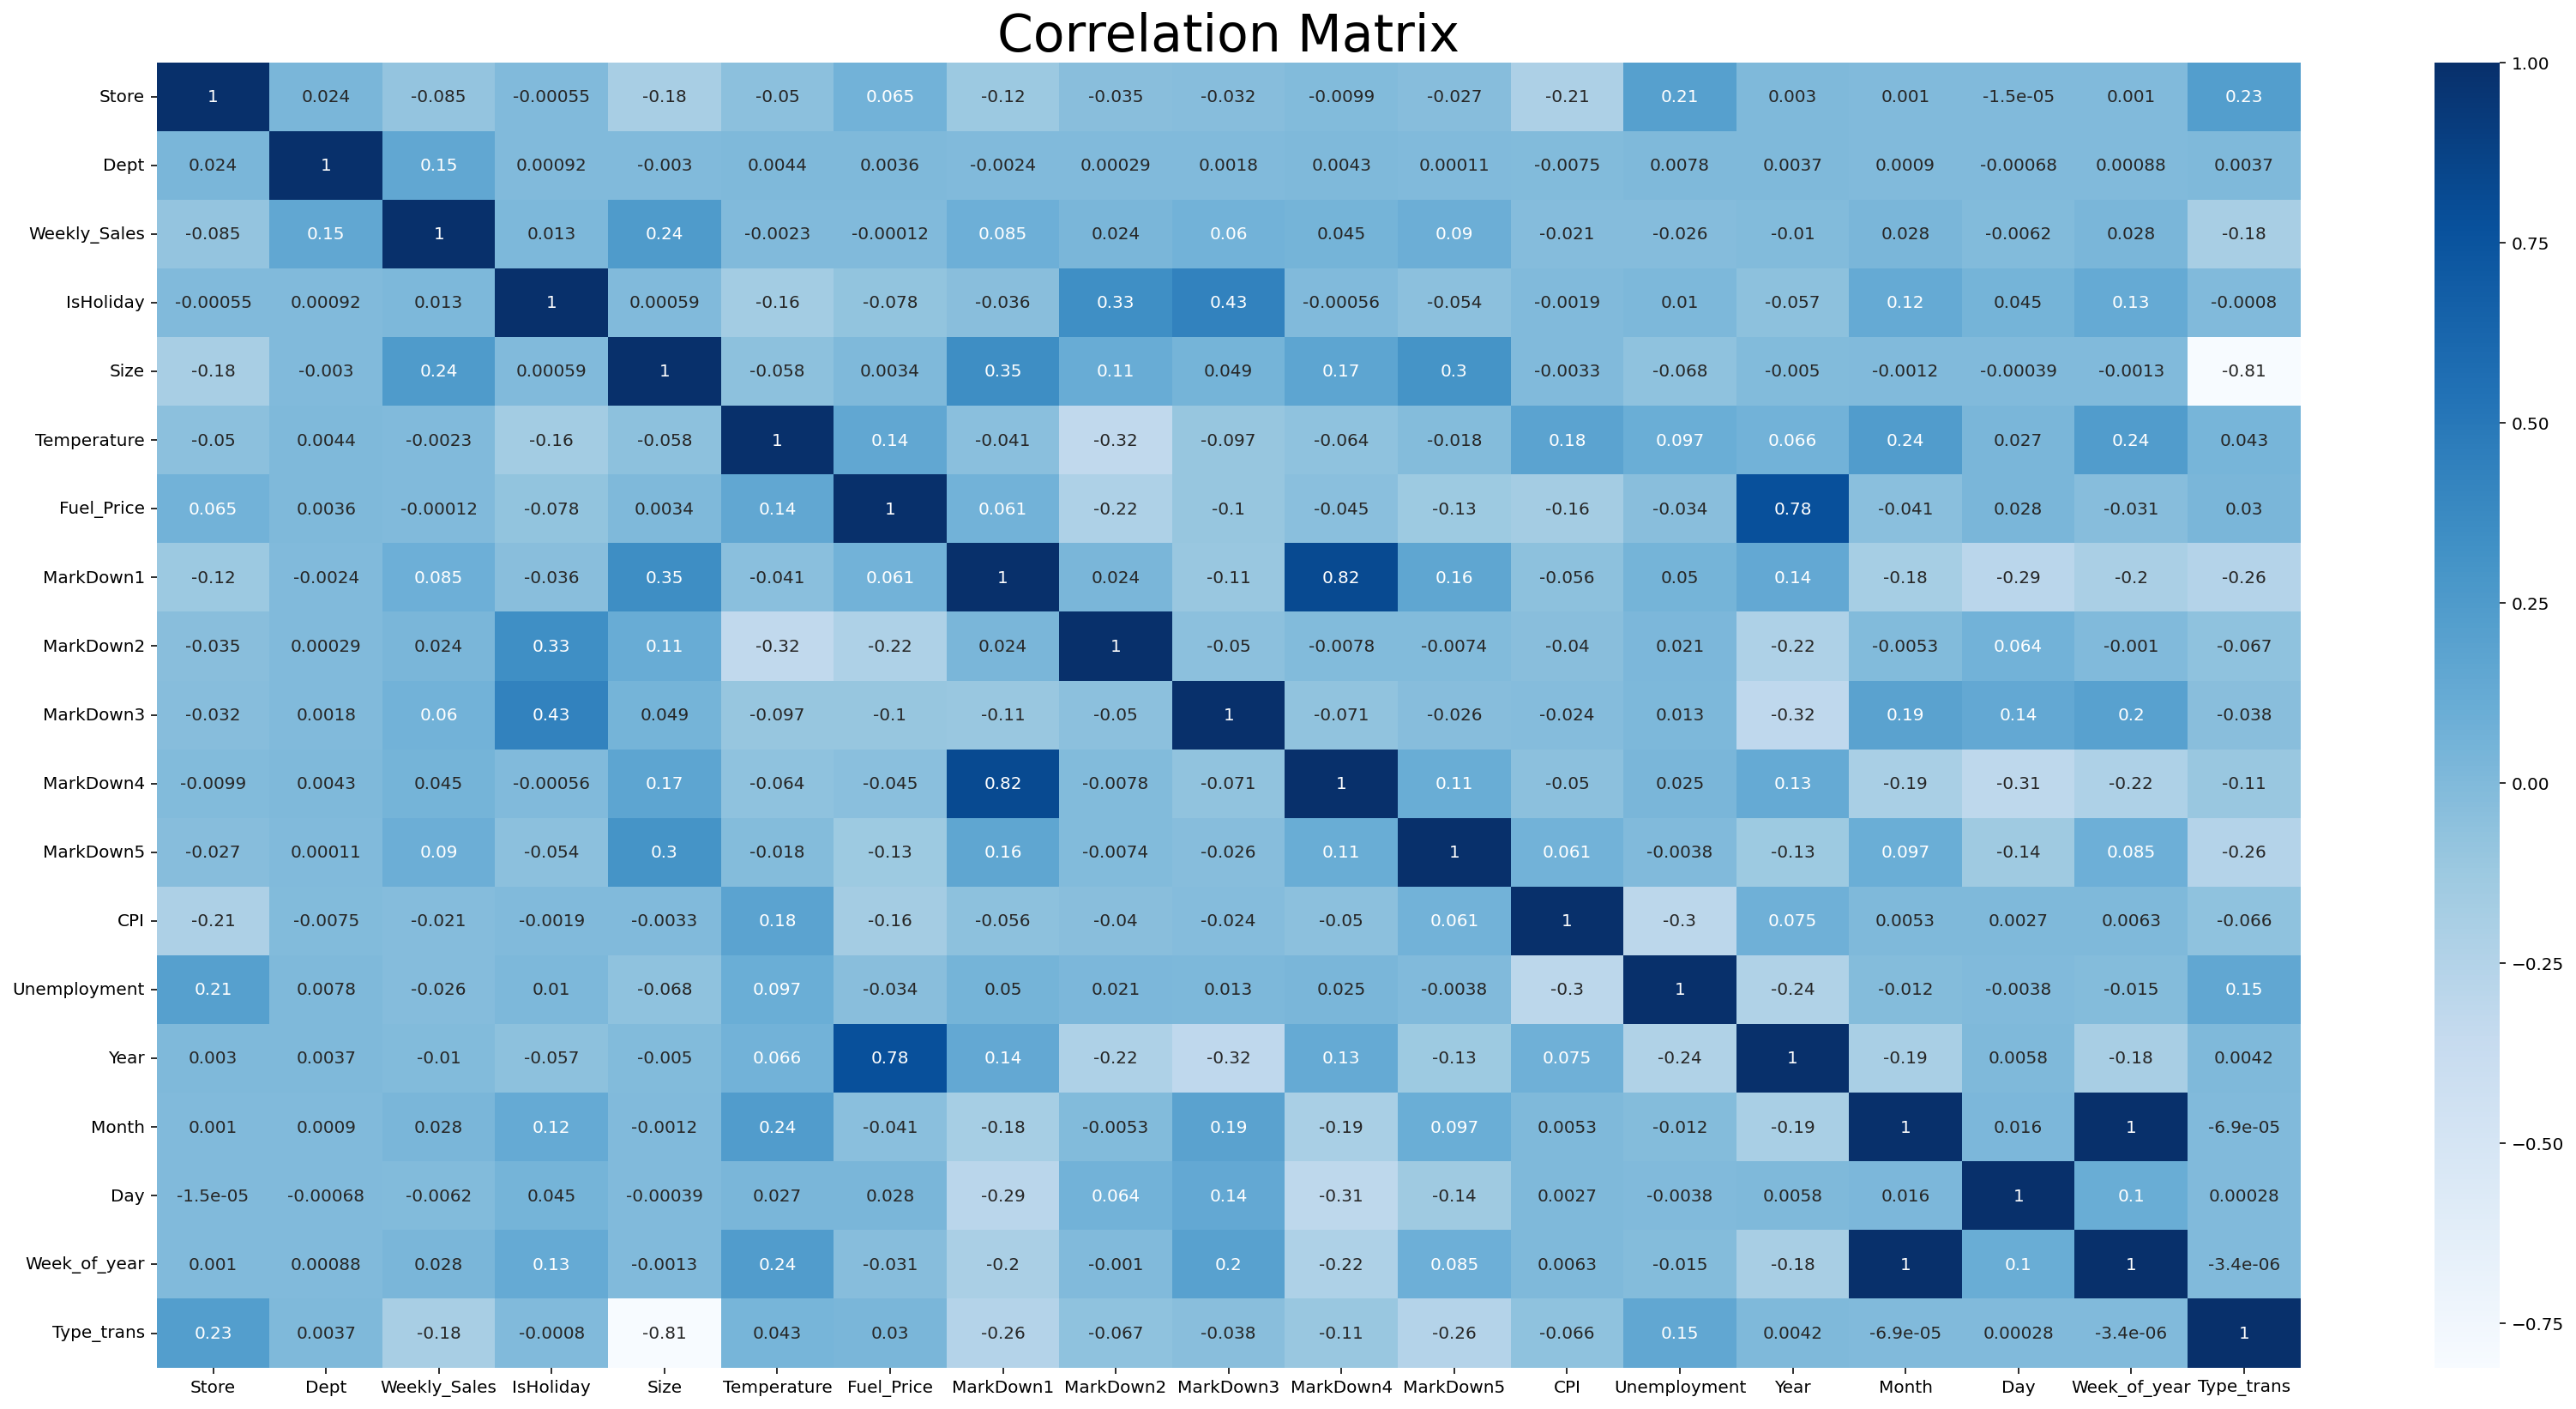

In [28]:
plt.figure(figsize=(28,14))
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Matrix', fontsize=30)
plt.show()

In [29]:
df_model = df.drop(columns=['Temperature', 'Type', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'CPI', 'Unemployment', 'Date', 'Month', 'Day'])
test_merge_model = test_merge.drop(columns=['Temperature', 'Type', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'CPI', 'Unemployment', 'Date', 'Month', 'Day'])

In [30]:
X = df_model.drop(columns=['Weekly_Sales'])
y = df_model['Weekly_Sales']

In [31]:
scaler = MinMaxScaler().fit(X)
X_scaler = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_scaler, y, test_size=0.2, random_state=123)

In [33]:
def WMAE(data, prediction, actual):
    weights = data['IsHoliday'].apply(lambda x: 5 if x==1 else 1)
    return np.round(np.sum(weights*abs(prediction-actual))/weights.sum(), 2)

1. Linear regression

In [34]:

model1 = LinearRegression().fit(X_train, y_train)
linear_train_wmae = WMAE(X_train, model1.predict(X_train), y_train)
y_pred = model1.predict(X_val)
linear_val_wmae = WMAE(X_val, y_pred, y_val)
print('Training dataset WMAE is', linear_train_wmae)
print('Validation dataset WMAE is', linear_val_wmae)

Training dataset WMAE is 14839.38
Validation dataset WMAE is 14774.55


2. Ridge Regression

In [35]:
model2 = Ridge().fit(X_train, y_train)
ridge_train_wmae = WMAE(X_train, model2.predict(X_train), y_train)


y_pred = model2.predict(X_val)
ridge_val_wmae = WMAE(X_val, y_pred, y_val)


print('Training dataset WMAE is', ridge_train_wmae)
print('Validation dataset WMAE is', ridge_val_wmae)

Training dataset WMAE is 14839.35
Validation dataset WMAE is 14774.52


3. Decision tree

In [36]:
model3 = DecisionTreeRegressor(random_state=123).fit(X_train, y_train)
tree_train_wmae = WMAE(X_train, model3.predict(X_train), y_train)

#validation error
y_pred = model3.predict(X_val)
tree_val_wmae = WMAE(X_val, y_pred, y_val)

#results:
print('Training dataset WMAE is', tree_train_wmae)
print('Validation dataset WMAE is', tree_val_wmae)

Training dataset WMAE is 0.0
Validation dataset WMAE is 1781.92


In [38]:
tree_importance = pd.DataFrame(np.transpose(model3.feature_importances_),
index=X_train.columns, columns=['Importance']).sort_values(by='Importance',ascending=False)
                                                                                                           
tree_importance

,Importance
Dept,0.634021
Size,0.203000
Store,0.075448
Week_of_year,0.064005
Type_trans,0.014366
Year,0.007283
IsHoliday,0.001875


4. Random Forest

In [40]:
model4 = RandomForestRegressor(random_state=123, n_jobs=-1).fit(X_train, y_train)
#train error
forest_train_wmae = WMAE(X_train, model3.predict(X_train), y_train)

#validation error
y_pred = model3.predict(X_val)
forest_val_wmae = WMAE(X_val, y_pred, y_val)

#results:
print('Training dataset WMAE is', forest_train_wmae)
print('Validation dataset WMAE is', forest_val_wmae)

Training dataset WMAE is 0.0
Validation dataset WMAE is 1781.92


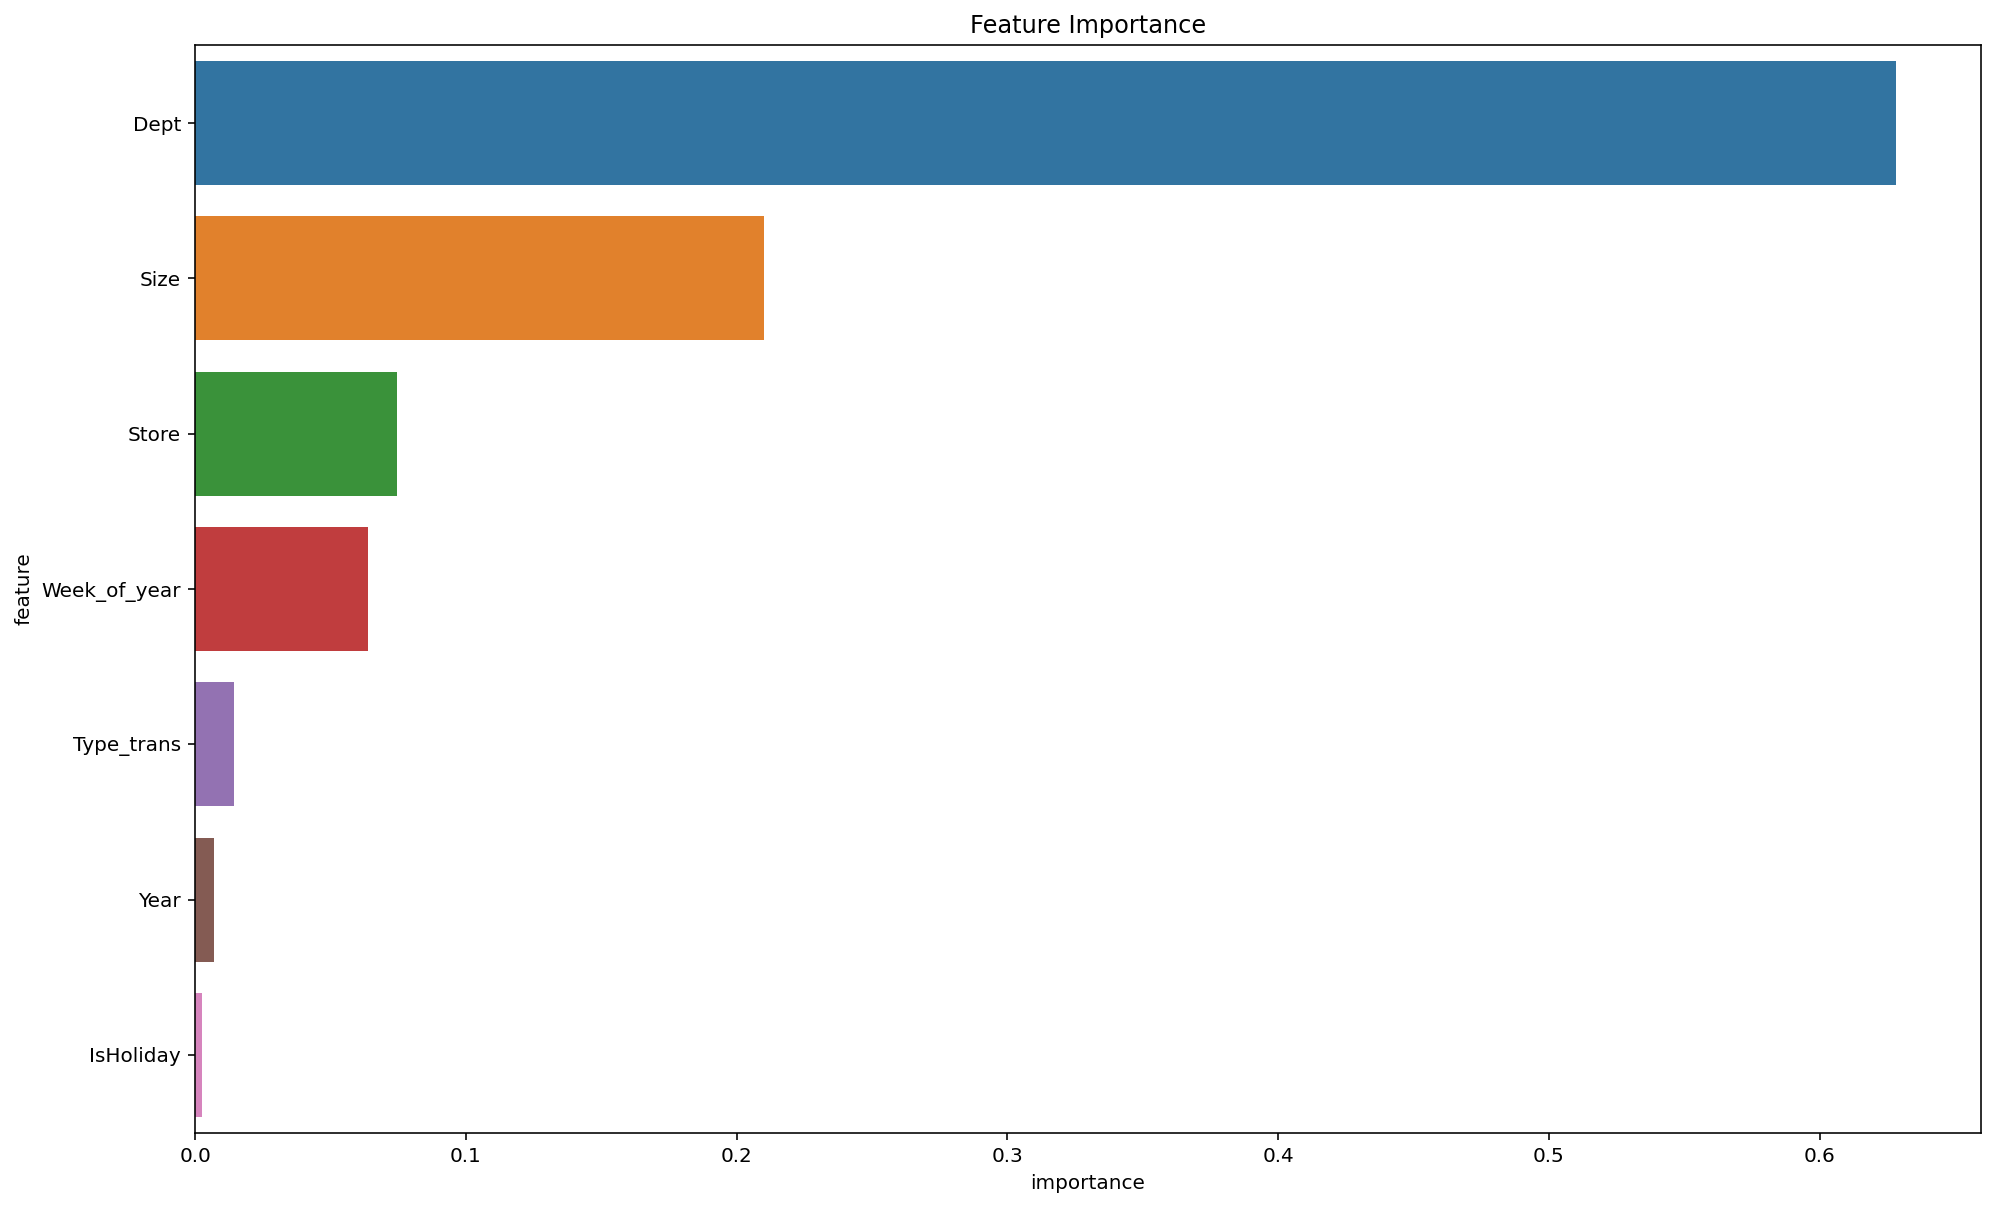

In [41]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model4.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

## RandomForest Hyperparameter Tuning
There are many hyperparameters in RandomForest model, and these together influence the performance of the model. In this case, finding the best one from finite combinations is needed. And I choose 'n_estimators', 'max_depth', 'min_samples_split', 'max_features'.

In [42]:
def test_params(**params):  
    model = RandomForestRegressor(random_state=123, n_jobs=-1, **params).fit(X_train, y_train)
    train_wmae = WMAE(X_train, y_train, model.predict(X_train))
    val_wmae = WMAE(X_val, y_val, model.predict(X_val))
    return train_wmae, val_wmae

In [43]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(**params)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

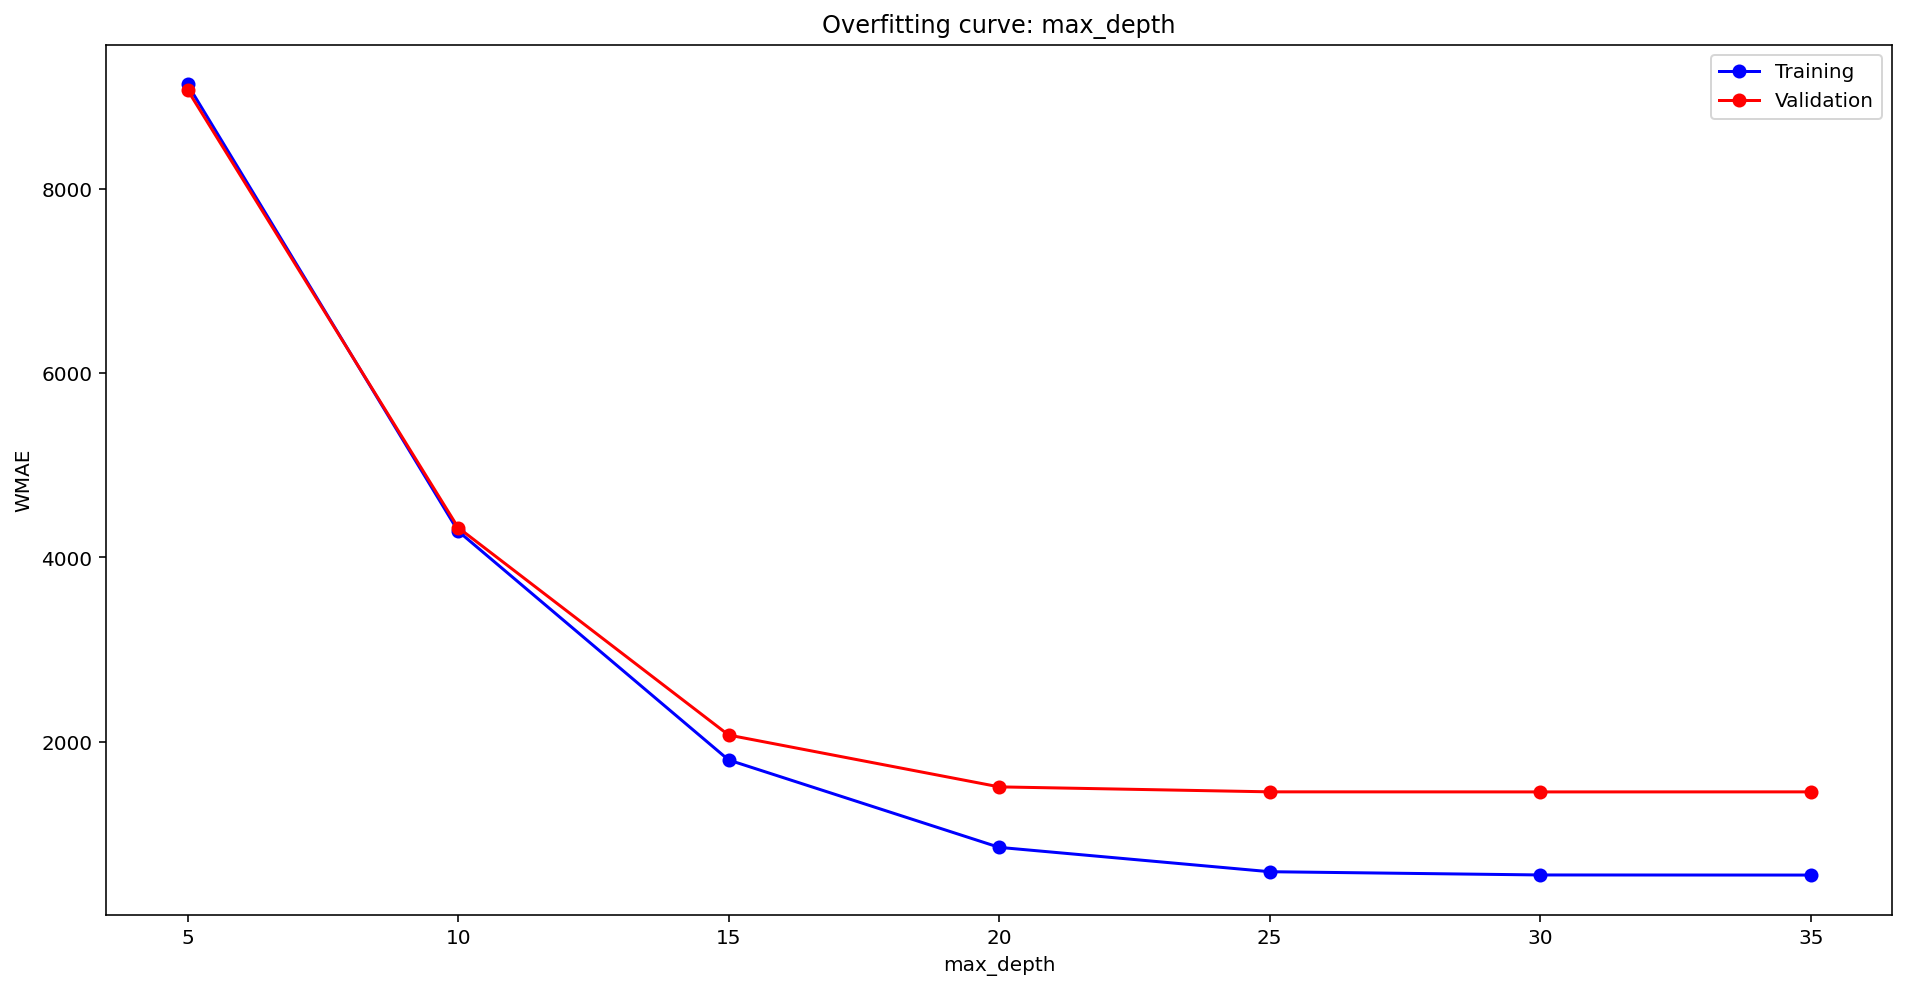

In [44]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

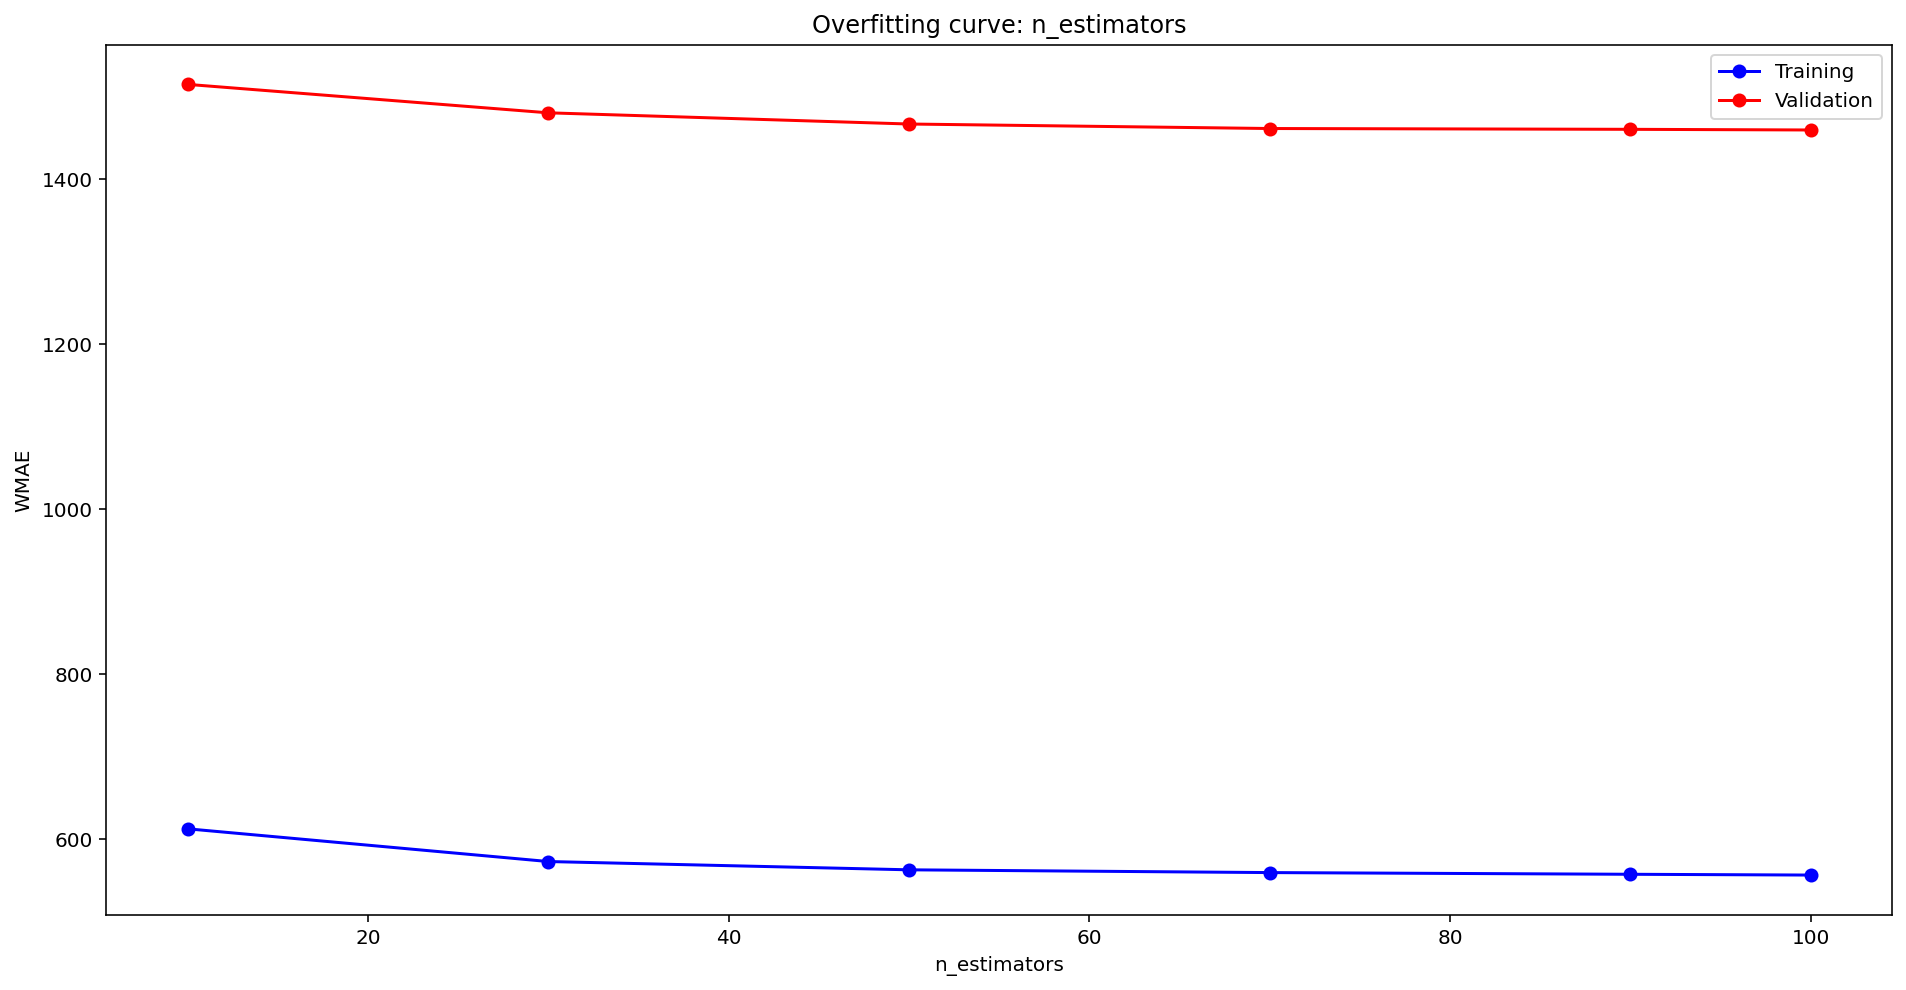

In [45]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])

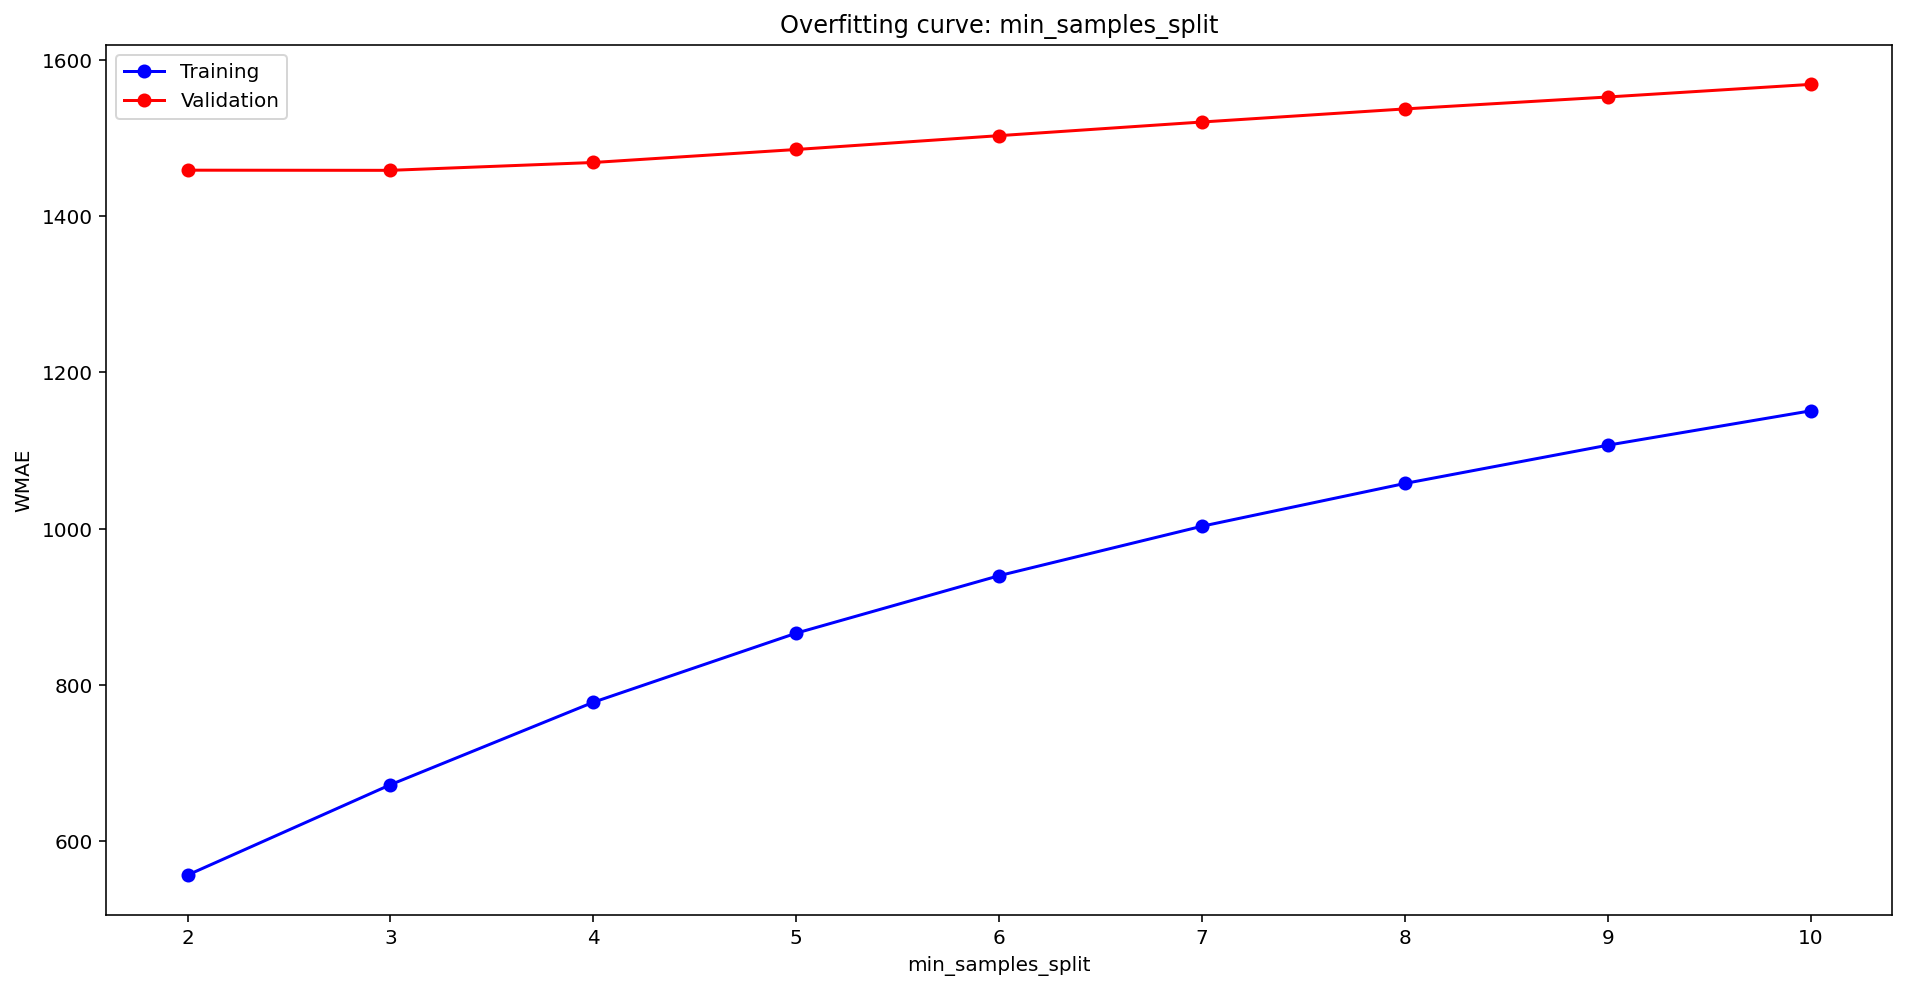

In [46]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

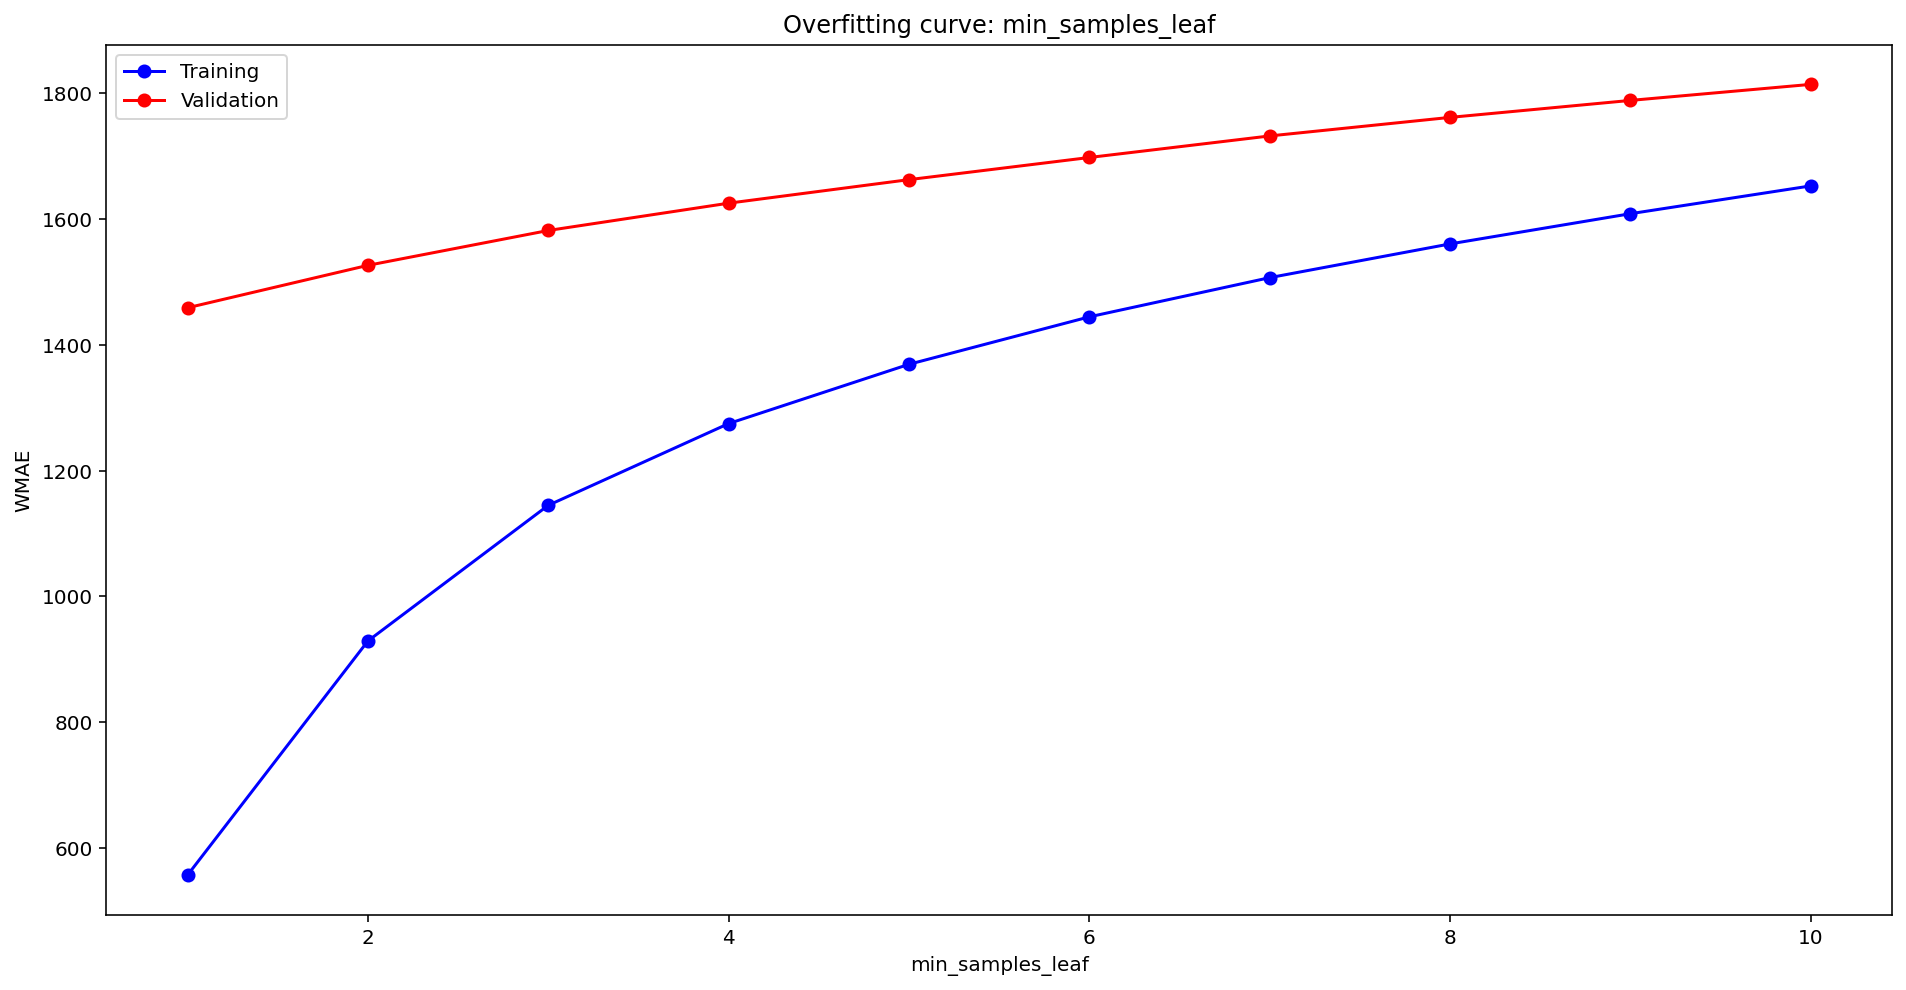

In [47]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

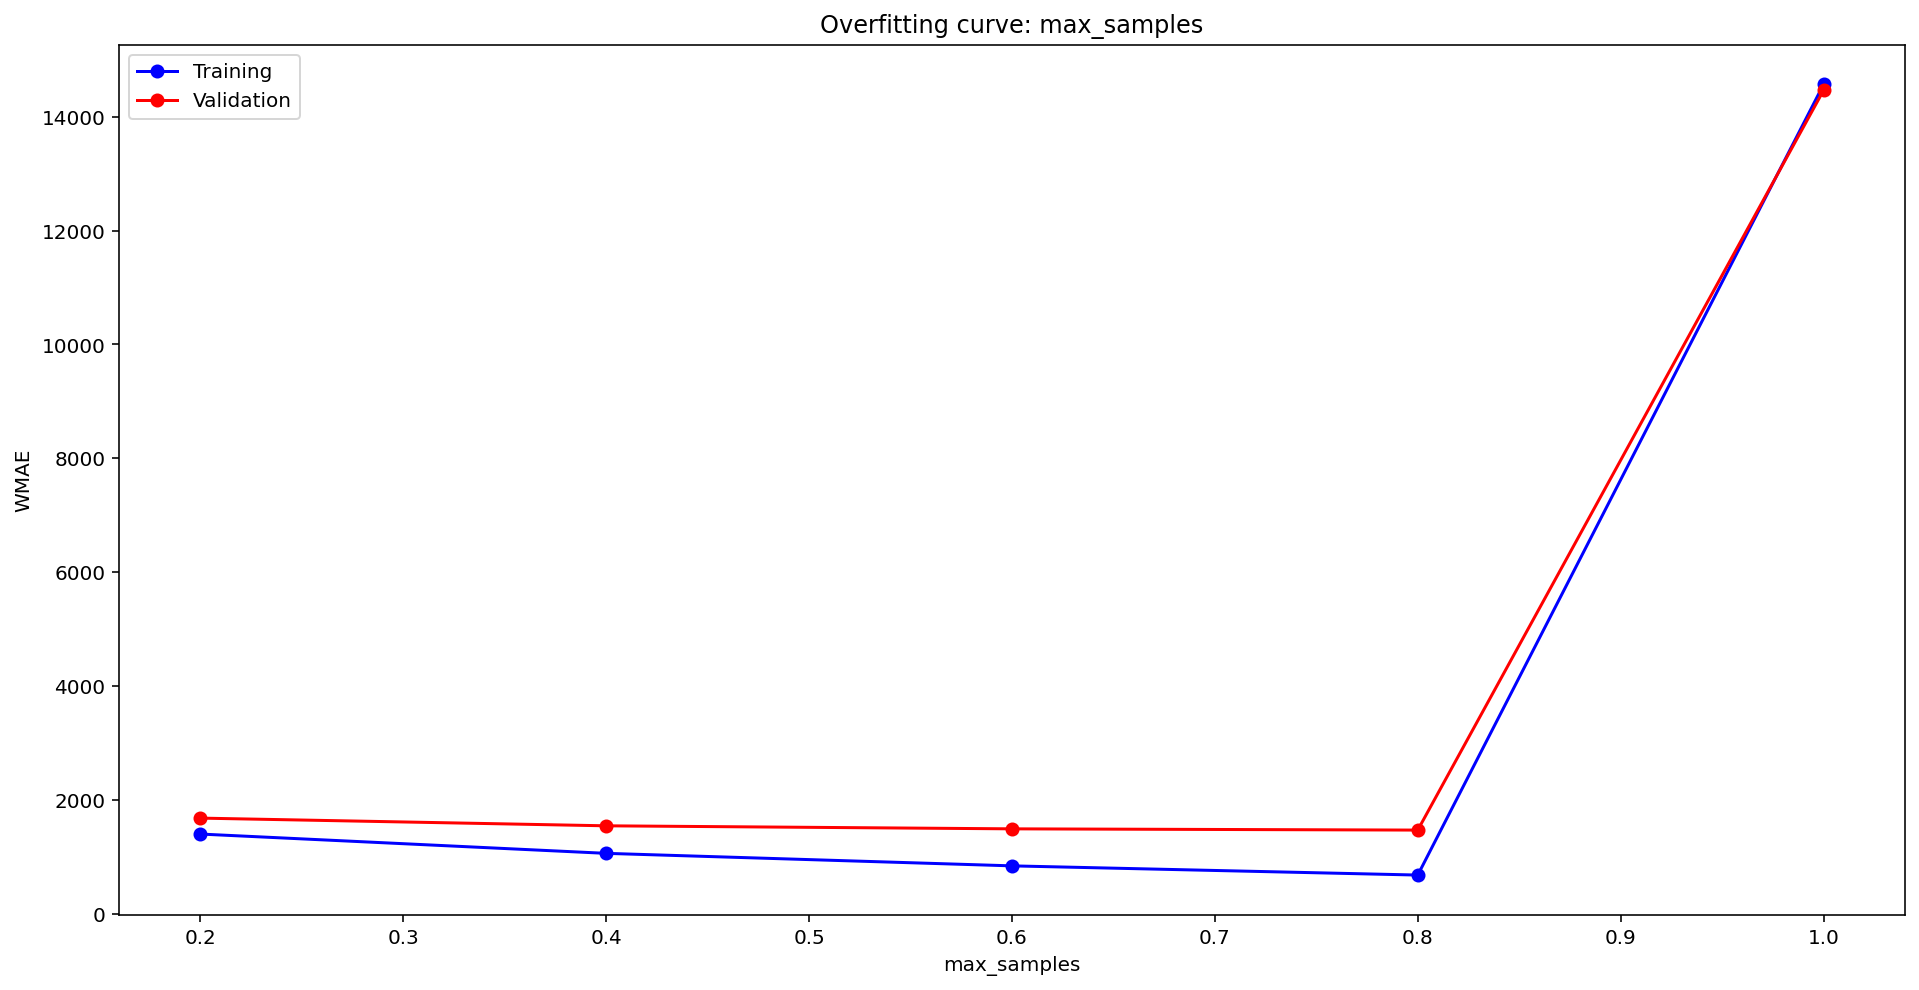

In [48]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])

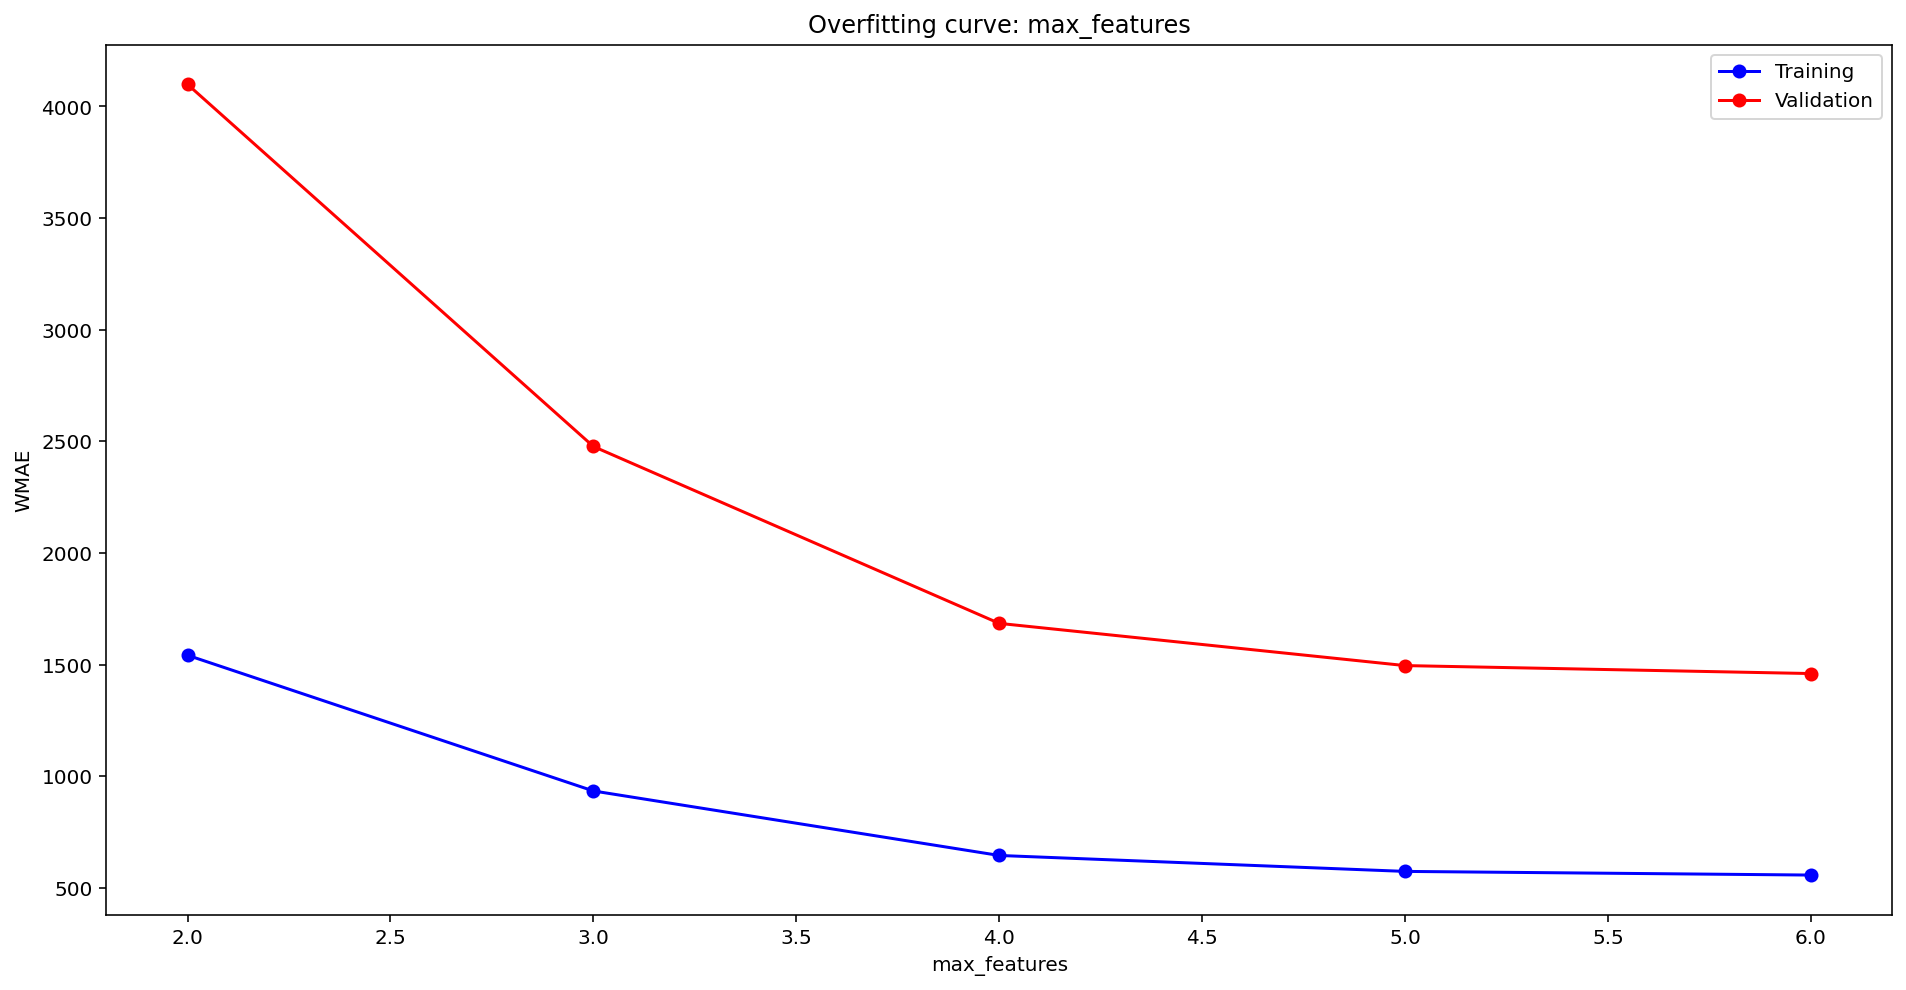

In [49]:
test_param_and_plot('max_features', [2, 3, 4, 5, 6])

From the above testing of parameters, the follwoing values of parameters were found to be the best which minimizes the validation error.

max_depth: 25

n_estimators: 100

min_samples_split: 2

min_samples_leaf: 1

max_samples: 0.8

max_features: 6

In [50]:
#Create the model
rf1 = RandomForestRegressor(max_depth=25, n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_samples=0.8, max_features=6,  random_state=123)

# Fit the model
rf1.fit(X_train, y_train)

rf1_train_pred = rf1.predict(X_train)

# Compute WMAE on traing data
rf1_train_wmae = WMAE(X_train, y_train, rf1_train_pred)
print('The WMAE loss for the training set is  {}.'.format(rf1_train_wmae))

rf1_val_preds = rf1.predict(X_val)

# Compute WMAE on validation data
rf1_val_wmae = WMAE(X_val, y_val, rf1_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(rf1_val_wmae))

The WMAE loss for the training set is  711.43.
The WMAE loss for the validation set is  1471.64.


5. XgBoosting

In [51]:
# Create the model
xgb = XGBRegressor(random_state=123)
model5 = xgb.fit(X_train, y_train)
#train error
xgb_train_wmae = WMAE(X_train, model5.predict(X_train), y_train)

#validation error
xgb_pred = model5.predict(X_val)
xgb_val_wmae = WMAE(X_val, xgb_pred, y_val)

#results:
print('Training dataset WMAE is', xgb_train_wmae)
print('Validation dataset WMAE is', xgb_val_wmae)

Training dataset WMAE is 3010.64
Validation dataset WMAE is 3063.59


XgBoosting Hyperparameter Tuning

In [52]:
importance_df_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model5.feature_importances_
}).sort_values('importance', ascending=False)



importance_df_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model4.feature_importances_
}).sort_values('importance', ascending=False)

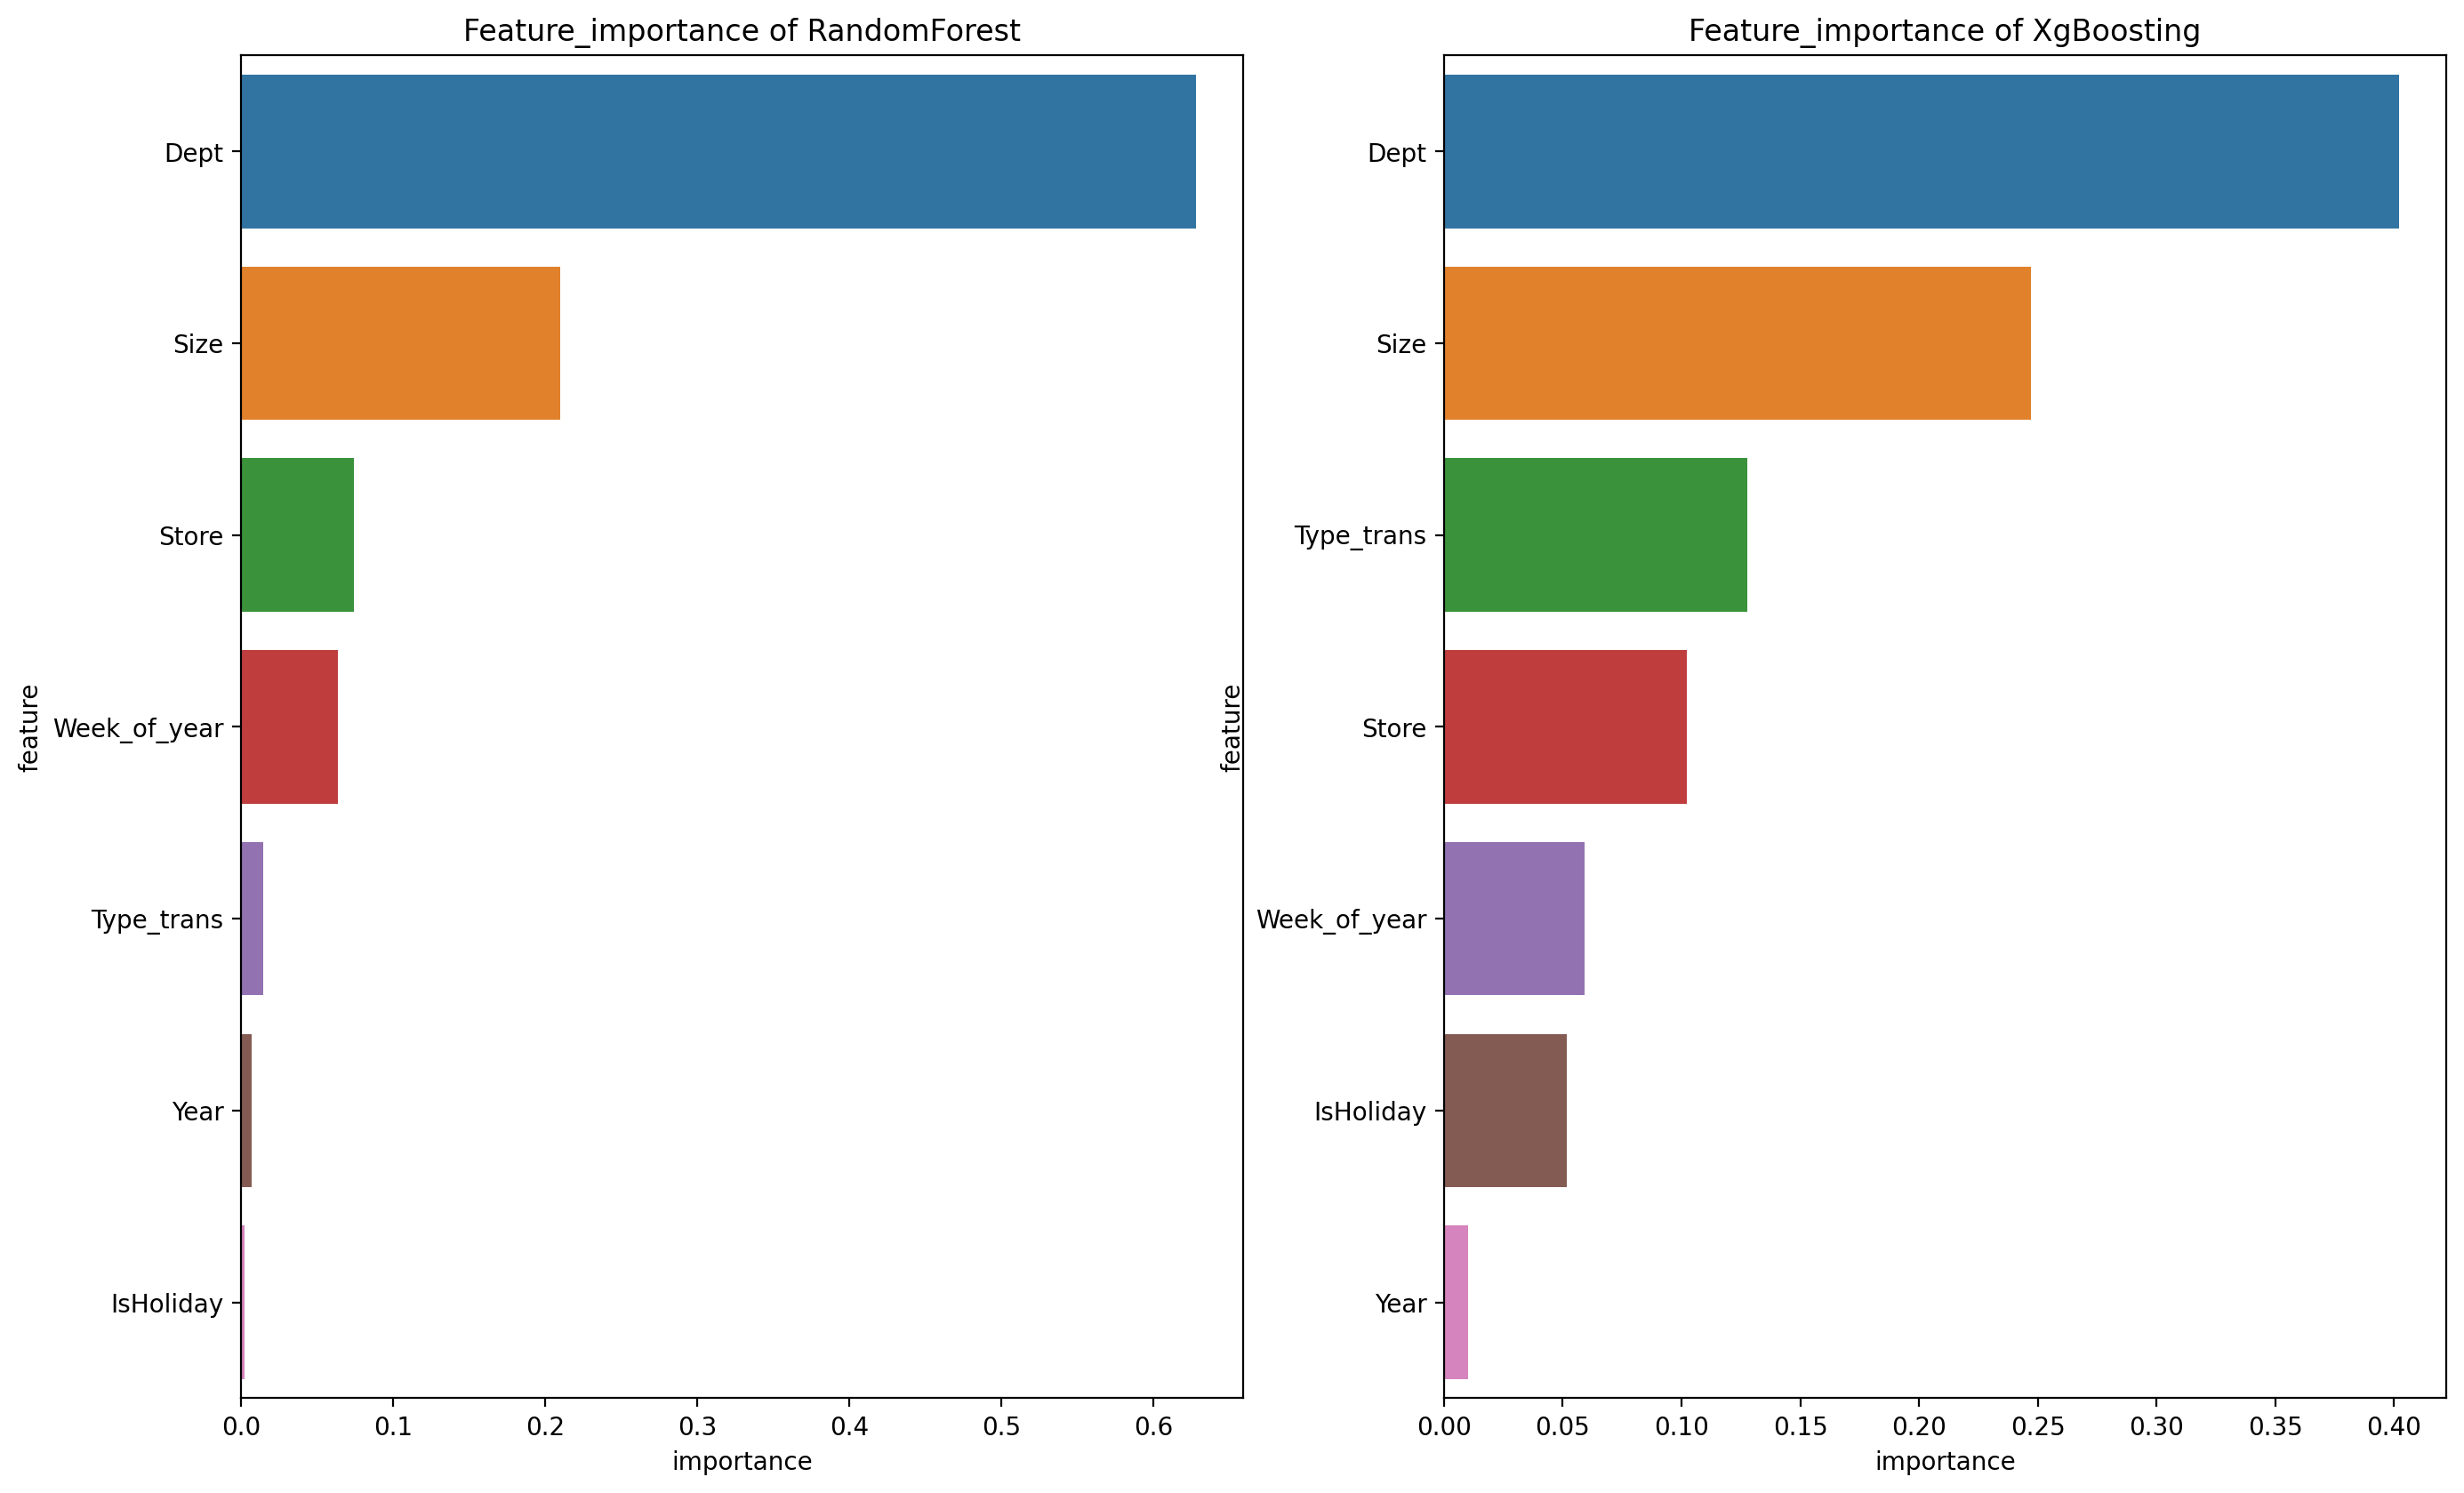

In [53]:
fig, axes = plt.subplots(1,2, figsize=(16,10), dpi=100)

ax1 = sns.barplot(data=importance_df_rf, x='importance', y='feature', ax=axes[0])
ax1.set_title('Feature_importance of RandomForest')

ax2 = sns.barplot(data=importance_df_xgb, x='importance', y='feature', ax=axes[1])
ax2.set_title('Feature_importance of XgBoosting')

plt.show()

Xgboosting Hyperparameter Tuning

In [54]:
def test_params_xgb(**params):  
    model = XGBRegressor(random_state=123, **params).fit(X_train, y_train)
    train_wmae = WMAE(X_train, y_train, model.predict(X_train))
    val_wmae = WMAE(X_val, y_val, model.predict(X_val))
    return train_wmae, val_wmae

In [55]:
def test_param_and_plot_xgb(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params_xgb(**params)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

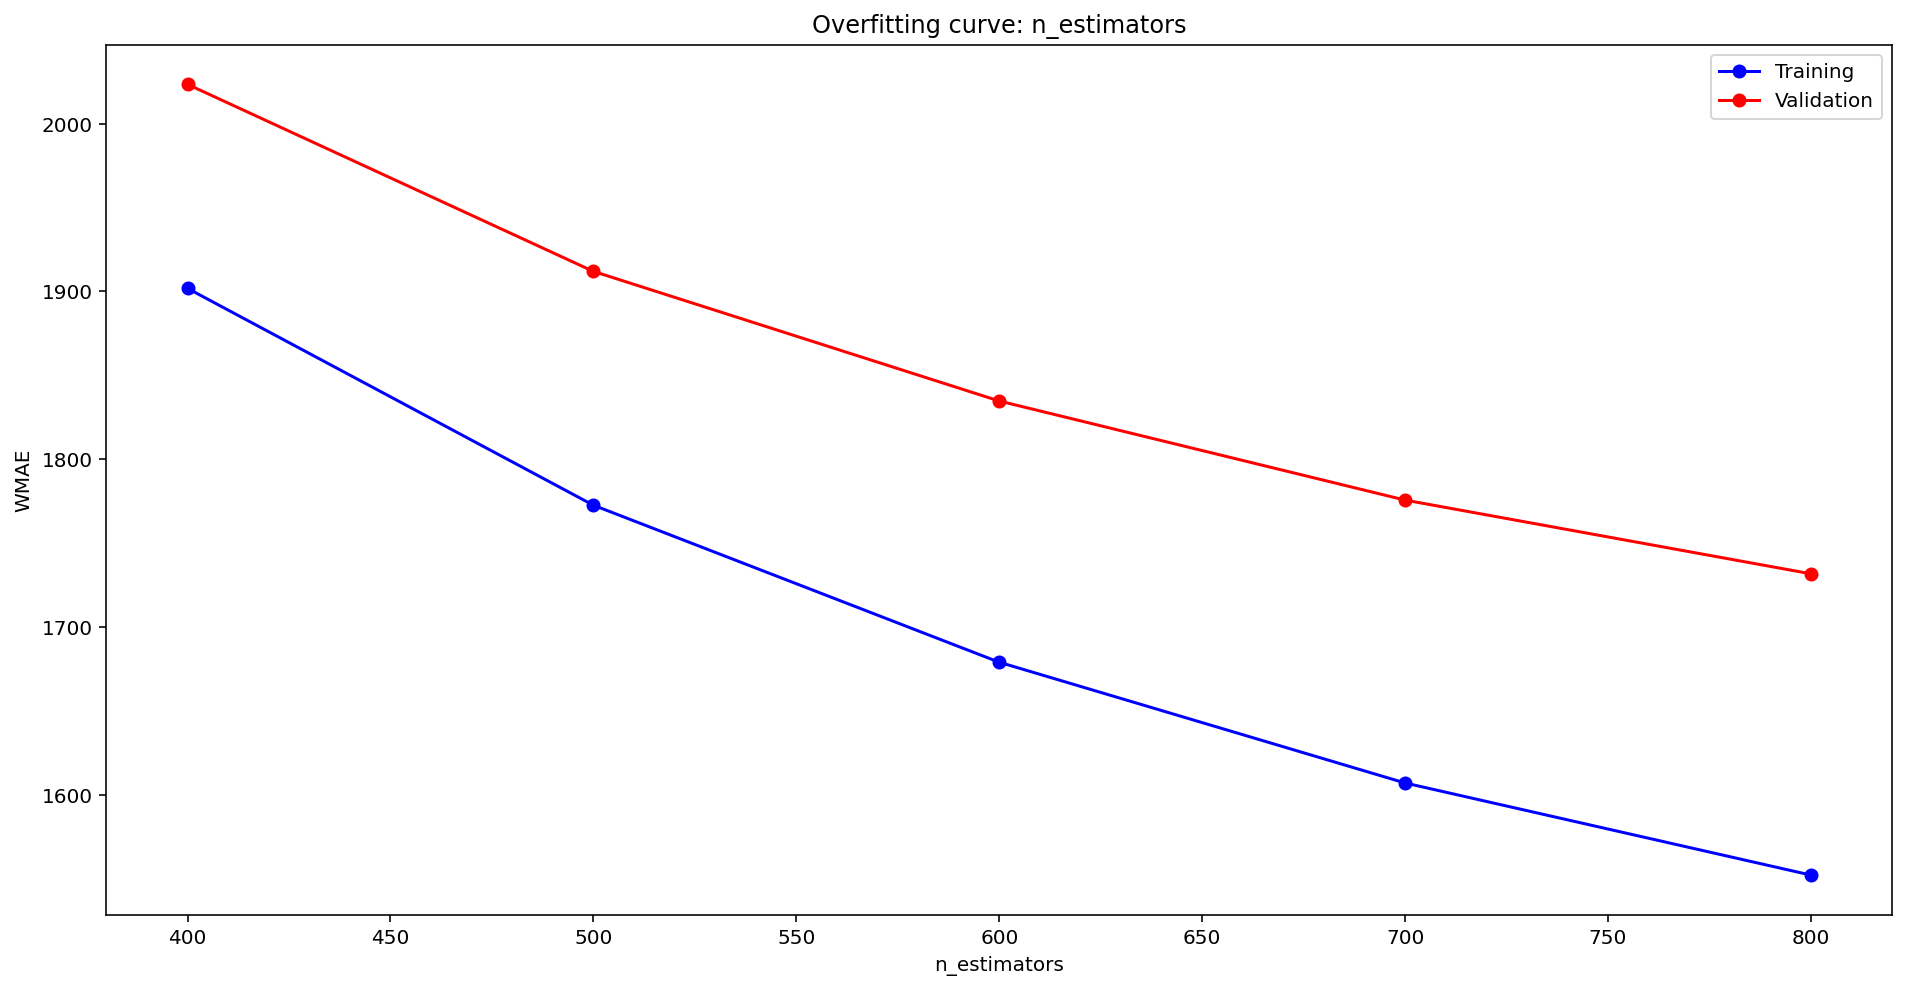

In [56]:
test_param_and_plot_xgb('n_estimators', [400,500,600,700,800])

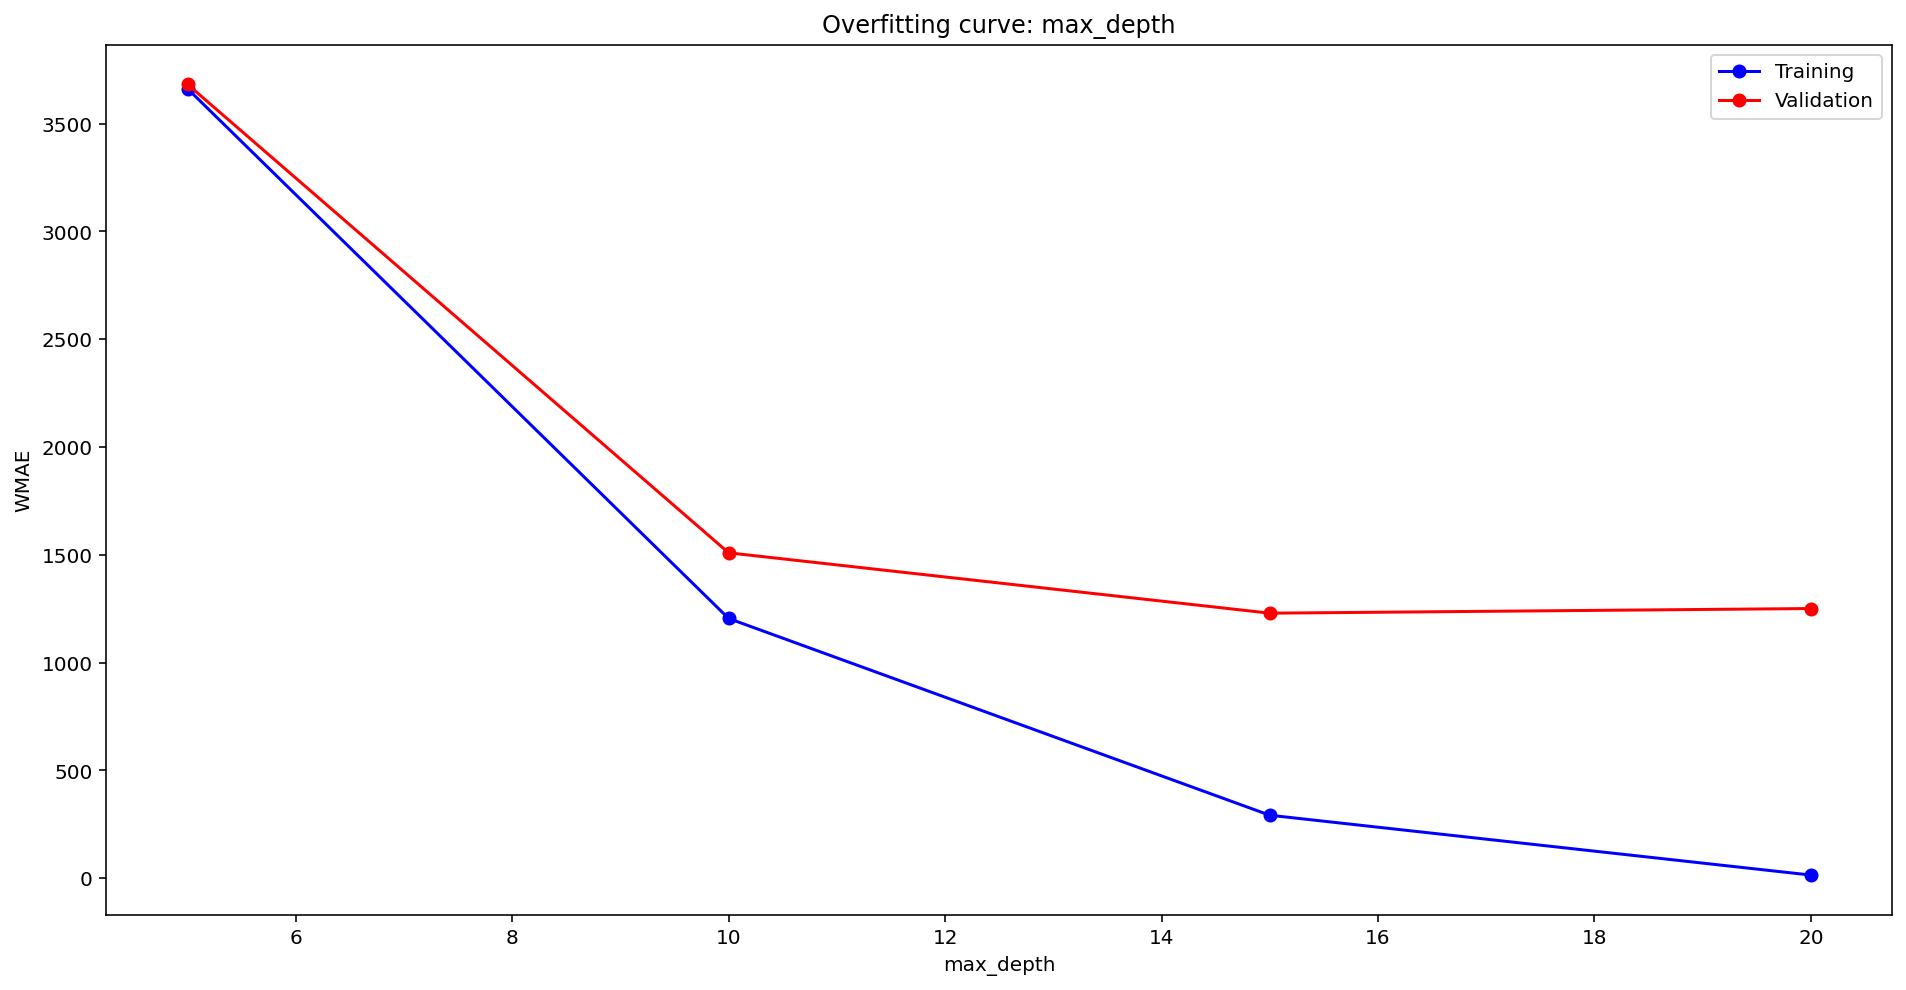

In [57]:
test_param_and_plot_xgb('max_depth', [5, 10, 15, 20])

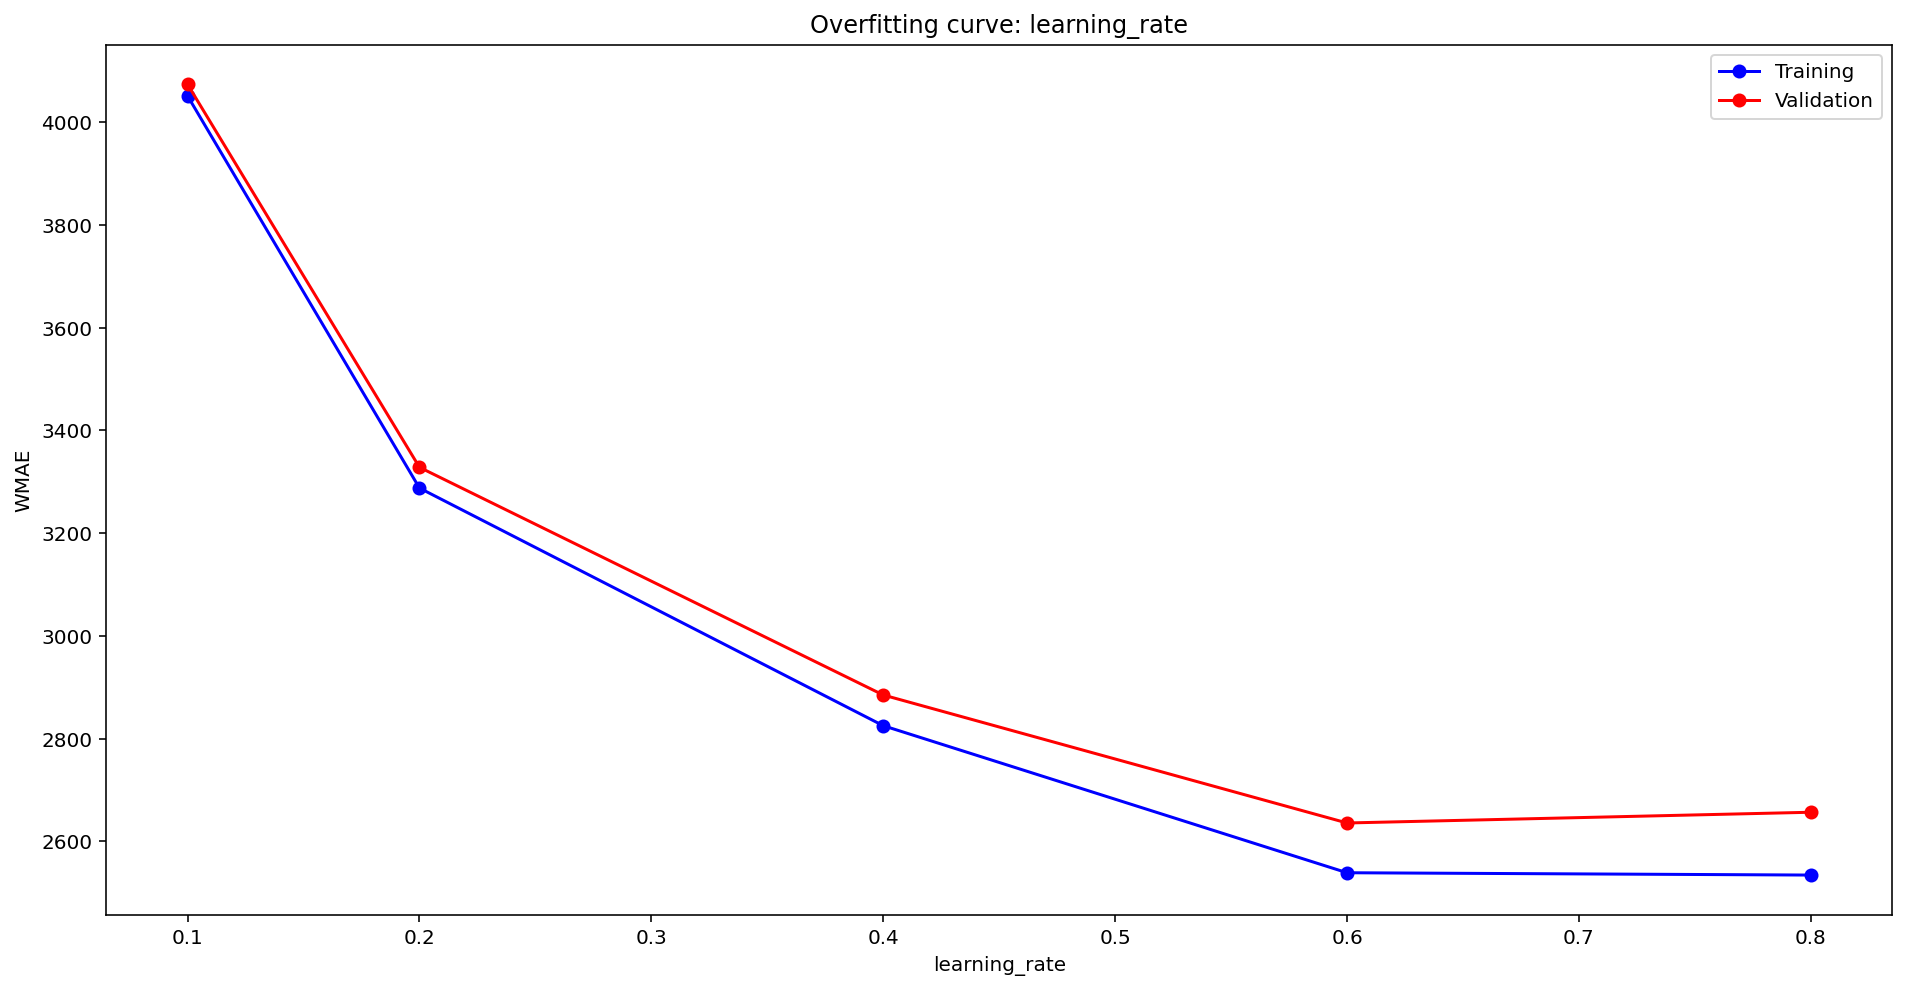

In [58]:
test_param_and_plot_xgb('learning_rate', [0.1, 0.2, 0.4, 0.6, 0.8])

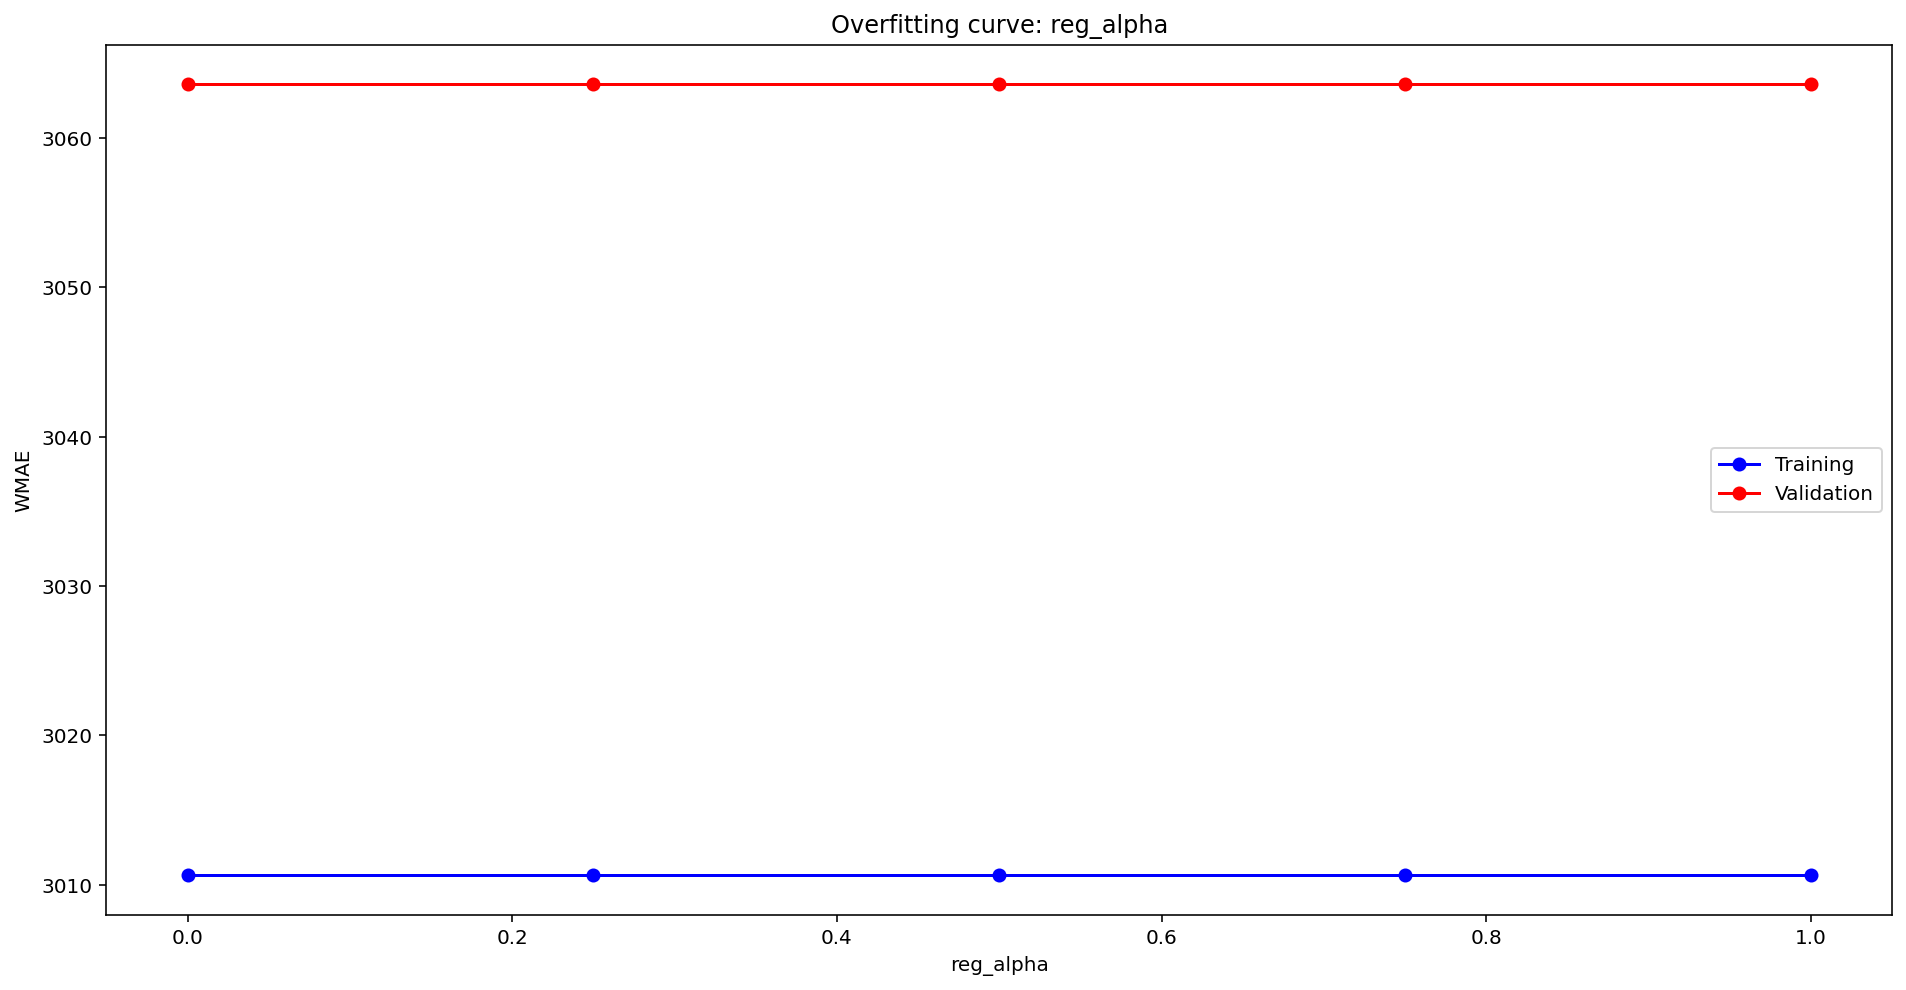

In [59]:
test_param_and_plot_xgb('reg_alpha', [0, 0.25, 0.5, 0.75, 1])

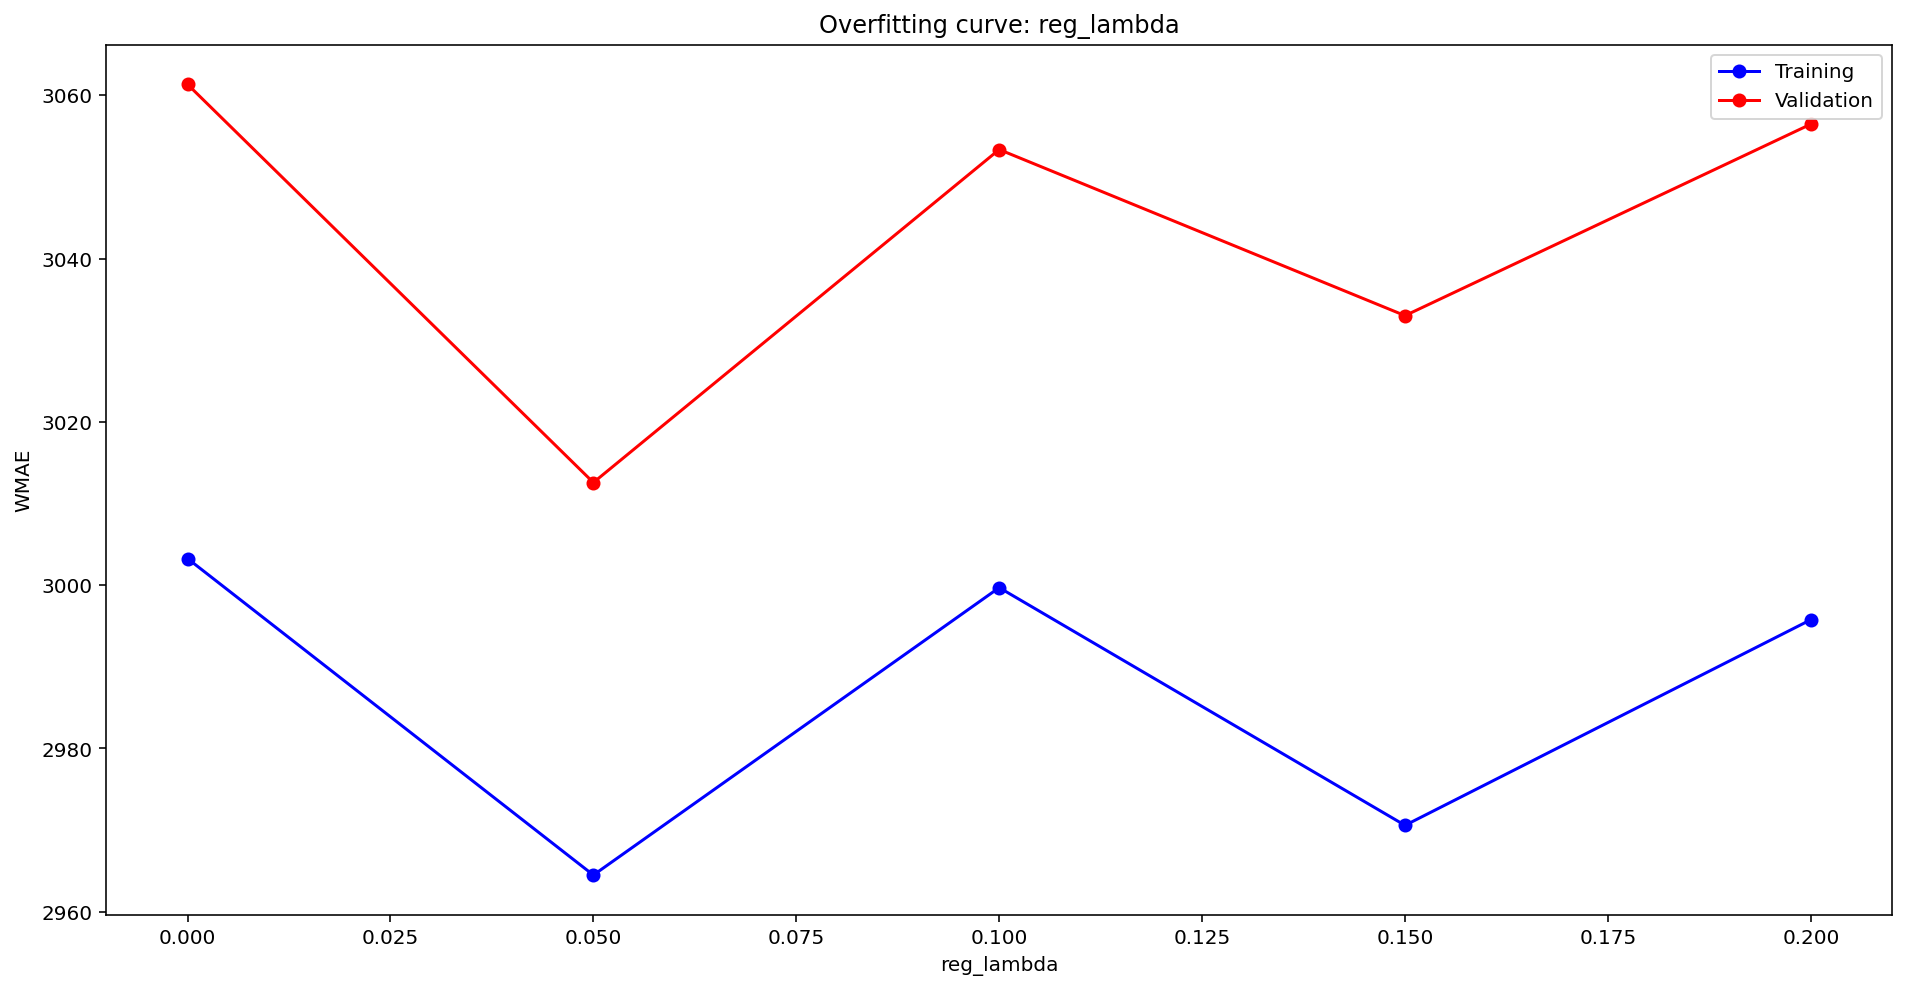

In [60]:
test_param_and_plot_xgb('reg_lambda', [0, 0.05, 0.1, 0.15, 0.2])

max_depth: 15

n_estimators: 800

learning_rate: 0.6

reg_alpha: 0 (default)

reg_lambda:1 (default)

In [61]:
# Create the model
xgb1 = XGBRegressor(random_state=123, n_estimators=800,
                    learning_rate = 0.6, max_depth=15)

# Fit the model
xgb1.fit(X_train, y_train)



# Compute WMAE on traing data
xgb1_train_preds = xgb1.predict(X_train)
xgb1_train_wmae = WMAE(X_train, y_train, xgb1_train_preds)
print('The WMAE loss for the training set is  {}.'.format(xgb1_train_wmae))



# Compute WMAE on validation data
xgb1_val_preds = xgb1.predict(X_val)
xgb1_val_wmae = WMAE(X_val, y_val, xgb1_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(xgb1_val_wmae))

The WMAE loss for the training set is  0.03.
The WMAE loss for the validation set is  1368.12.


# 4. Models Comparison
### Linear Regression
#### WMAE for Training set: 14776.33
#### WMAE for Validation set: 14884.34
#### WMAE for Training set: 14839.35
#### WMAE for Validation set: 14774.52
#### WMAE for Training set: 0.0
#### WMAE for Validation set:
#### WMAE for Training set: 569.99
#### WMAE for Validation set: 1571.46
#### WMAE for Training set: 16.66
#### WMAE for Validation set: 1339.29

### Linear Regression
#### Training dataset WMAE is 14839.38
#### Validation dataset WMAE is 14774.55
### Ridge Regression
#### Training dataset WMAE is 14839.35
#### Validation dataset WMAE is 14774.52
### Decision Tree
#### Training dataset WMAE is 0.0
#### Validation dataset WMAE is 1781.92

### Random Forest
#### The WMAE loss for the training set is 711.43.
#### The WMAE loss for the validation set is 1471.64.
### Gradient Boosting Machine
#### The WMAE loss for the training set is 0.03.
#### The WMAE loss for the validation set is 1368.12.

# 5. Conclusions
#### Following inferences and conclusions can be drawn from the the analysis of the data:

#### 1.Type 'A' stores are more popular than 'B' and 'C' types.

#### 2.Type 'A' stores outclass the 'B' and 'C' types in terms of size and the avergae weekly sales.

#### 3.Weekly Sales are affected by the week of year. Holiday weeks witnessed more sales than the non-holiday weeks. Notables are Thanksgiving and Christmas weeks.

#### 4.Size of the store is a major contributing factor in the weekly sales.

#### 5.Sales are also dependent on the department of the store as different departments showed different levels of weekly sales.

#### 6.Among the trained models for predicting the future sales, Grdient Boosting Machine with tuned hyperparameters performs the best.